# Taco Sales Analytics & Forecasting (2024–2025)

This notebook performs **end-to-end exploratory data analysis (EDA), forecasting, and price optimization** on taco sales data from 2024–2025.  
The goal is to provide insights and predictions that can support business decisions such as **inventory planning, pricing, and promotions**.


## Import Libraries 

In this section, we import all necessary libraries for data manipulation, visualization, time series modeling, machine learning, and evaluation. This upfront import ensures all required tools are available throughout the analysis.

In [1]:
# System & utilities
import warnings
warnings.filterwarnings("ignore")

# Data handling and manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid", palette="husl")

# Time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Cross-validation for time series
from sklearn.model_selection import TimeSeriesSplit

# ML models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# 📥 1. Data Ingestion & Cleaning
 
In this step, we:  
- Load the **Taco Sales dataset (2024–2025)**.  
- Inspect the structure of the dataset and check for **missing values or anomalies**.  
- Ensure **date columns are parsed correctly** for time series analysis.  
- Create a **base time series table** that will serve as the foundation for exploratory data analysis (EDA) and forecasting.


## 📥 1.1 Load Taco Sales Dataset

In [2]:
# Read CSV with day-first format (in case of DD/MM/YYYY)
data = pd.read_csv("Tacos_dataset.csv", dayfirst=True)
df=data.copy()
# Preview first few rows
df.head(3)


,Order ID,Restaurant Name,Location,Order Time,Delivery Time,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
0,770487,El Taco Loco,New York,01-08-2024 14:55,01-08-2024 15:36,41,Regular,Chicken Taco,5,3.01,9.25,2.22,False
1,671858,El Taco Loco,San Antonio,23-11-2024 17:11,23-11-2024 17:25,14,Regular,Beef Taco,1,6.20,4.25,3.01,True
2,688508,Taco Haven,Austin,21-11-2024 20:24,21-11-2024 21:02,38,Large,Pork Taco,2,20.33,7.00,0.02,False


## 🔎 1.2 Quick Dataset Overview  

Before proceeding with cleaning, let’s quickly inspect the dataset:  

- **Shape:** Number of rows and columns.  
- **Data types:** Ensure columns (especially date and numeric fields) are in the right format.  
- **Missing values:** Check if any data imputation is needed.  
- **Preview:** Display first 3 rows for context.  


In [3]:
# Data overview
print("Shape:", df.shape)
df.info()
print("\nMissing values:\n", df.isnull().sum())
display(df.head(3))


Shape: (1000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order ID                 1000 non-null   int64  
 1   Restaurant Name          1000 non-null   object 
 2   Location                 1000 non-null   object 
 3   Order Time               1000 non-null   object 
 4   Delivery Time            1000 non-null   object 
 5   Delivery Duration (min)  1000 non-null   int64  
 6   Taco Size                1000 non-null   object 
 7   Taco Type                1000 non-null   object 
 8   Toppings Count           1000 non-null   int64  
 9   Distance (km)            1000 non-null   float64
 10  Price ($)                1000 non-null   float64
 11  Tip ($)                  1000 non-null   float64
 12  Weekend Order            1000 non-null   bool   
dtypes: bool(1), float64(3), int64(3), object(6)
memory usage: 94.

,Order ID,Restaurant Name,Location,Order Time,Delivery Time,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
0,770487,El Taco Loco,New York,01-08-2024 14:55,01-08-2024 15:36,41,Regular,Chicken Taco,5,3.01,9.25,2.22,False
1,671858,El Taco Loco,San Antonio,23-11-2024 17:11,23-11-2024 17:25,14,Regular,Beef Taco,1,6.20,4.25,3.01,True
2,688508,Taco Haven,Austin,21-11-2024 20:24,21-11-2024 21:02,38,Large,Pork Taco,2,20.33,7.00,0.02,False


✅ Dataset has 1000 rows × 13 columns.  
✅ No missing values.  
⚠️ `Order_Time` and `Delivery_Time` are strings → convert to datetime.  
   

## 🧹 1.3 Clean Column Names
Stripped whitespace and replaced spaces with underscores `_`.  
Removed special characters except `$` (kept for monetary columns). 
Converted to lowercase.                                                  
✅ This improves readability and prevents errors when referencing columns in code. 


In [4]:

# 🧹 Clean column names
df.columns = (
    df.columns
    .str.strip()  # remove leading/trailing spaces
    .str.replace(" ", "_")  # replace spaces with underscores
    .str.replace(r"[^\w$]", "", regex=True)  # remove special chars except $
    .str.lower()
)
df.columns


Index(['order_id', 'restaurant_name', 'location', 'order_time',
       'delivery_time', 'delivery_duration_min', 'taco_size', 'taco_type',
       'toppings_count', 'distance_km', 'price_$', 'tip_$', 'weekend_order'],
      dtype='object')

## ⏱️ 1.4 Parse Datetime Columns
Identify and convert datetime fields for proper time-based analysis.
 

In [5]:
# ⏱️ Parse datetime columns
possible_dt_cols = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
print("Detected datetime columns:", possible_dt_cols)

for col in possible_dt_cols:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors="coerce")


Detected datetime columns: ['order_time', 'delivery_time']



- **Detected:** `['order_time', 'delivery_time']`.  
- Converted to `datetime`→ now usable for time-based analysis. 


## 🚦 1.5 Outliers & Anomalies Check 

- Start with distribution checks.
- Keep outliers for modeling unless clearly erroneous, but flag them.

In [6]:
# 🚦 Outliers & anomalies check
numeric_profile = df.select_dtypes(include=[np.number]).describe().T
display(numeric_profile)


,count,mean,std,min,25%,50%,75%,max
order_id,1000.0,552504.86500,255948.779709,101139.00,331796.7500,559740.00,771781.7500,999138.00
delivery_duration_min,1000.0,50.93000,23.227540,10.00,30.0000,53.00,71.0000,90.00
toppings_count,1000.0,2.52900,1.717005,0.00,1.0000,3.00,4.0000,5.00
distance_km,1000.0,13.07342,7.142268,0.51,6.9725,13.20,19.2425,24.98
price_$,1000.0,6.90825,2.310137,3.00,4.5000,6.75,9.2500,10.75
tip_$,1000.0,1.80611,1.132035,0.01,0.9075,1.76,2.5200,4.98


📌**Interpretation**

Delivery duration: **10–90 min**, mean ~51 min → realistic.

Toppings count: **0–5**, median = 3 → zero toppings valid.

Distance: **0.5–25 km** → no zeros or negative values.

Price: ~$7 on average → reasonable.

Tips: $0–5, average ~$1.8 → plausible variation.

✅ Decision: Keep all values, as they reflect natural variability (large orders, long deliveries, generous tips). 


## 📅 1.6 Features Engineering 

In [7]:
# 📅 Calendar feature engineering
df["order_date"] = df["order_time"].dt.date          # calendar date
df["dow"]        = df["order_time"].dt.dayofweek     # day of week (0=Mon)
df["week"]       = df["order_time"].dt.isocalendar().week.astype(int)  # ISO week number
df["month"]      = df["order_time"].dt.month         # month
df["hour"]       = df["order_time"].dt.hour          # hour of day

df.head(3)


,order_id,restaurant_name,location,order_time,delivery_time,delivery_duration_min,taco_size,taco_type,toppings_count,distance_km,price_$,tip_$,weekend_order,order_date,dow,week,month,hour
0,770487,El Taco Loco,New York,2024-08-01 14:55:00,2024-08-01 15:36:00,41,Regular,Chicken Taco,5,3.01,9.25,2.22,False,2024-08-01,3,31,8,14
1,671858,El Taco Loco,San Antonio,2024-11-23 17:11:00,2024-11-23 17:25:00,14,Regular,Beef Taco,1,6.20,4.25,3.01,True,2024-11-23,5,47,11,17
2,688508,Taco Haven,Austin,2024-11-21 20:24:00,2024-11-21 21:02:00,38,Large,Pork Taco,2,20.33,7.00,0.02,False,2024-11-21,3,47,11,20


- Created calendar features: order_date, dow, week, month, hour.
- 📌 These support **seasonality, trend, and time-of-day analysis** in EDA and forecasting.

## 📊 1.7 Time Series Base Table  


In [8]:
# 📊 Build daily base table
agg_map = {
    "order_id": "count",               # total orders placed that day
    "price_$": ["mean", "sum"],        # avg price/order, total sales revenue
    "tip_$": ["mean", "sum"],          # avg tip/order, total tips collected
    "delivery_duration_min": "mean",   # avg delivery time
    "distance_km": "mean"              # avg delivery distance
}

daily = (
    df
    .set_index("order_time")      # ensure datetime index
    .sort_index()
    .resample("D")
    .agg(agg_map)
)

# Flatten multi-index columns
daily.columns = [
    "_".join(col) if isinstance(col, tuple) else col
    for col in daily.columns
]

# Rename for clarity
daily = (
    daily.rename(columns={
        "order_id_count": "orders",
        "price_$_sum": "revenue",
        "price_$_mean": "avg_price",
        "tip_$_mean": "avg_tip",
        "tip_$_sum": "total_tip",
        "delivery_duration_min_mean": "avg_delivery_min",
        "distance_km_mean": "avg_distance_km"
    })
    .asfreq("D")
)

# Optional: flag and fill missing days
# Flags before filling
daily["filled"] = daily["orders"].isna()
daily["was_missing"] = daily["orders"].isnull()

daily.head(3)


,orders,avg_price,revenue,avg_tip,total_tip,avg_delivery_min,avg_distance_km,filled,was_missing
order_time,,,,,,,,,
2024-01-01,1,4.50,4.50,2.77,2.77,69.0,1.97,False,False
2024-01-02,1,5.75,5.75,0.71,0.71,58.0,13.48,False,False
2024-01-03,0,NaN,0.00,NaN,0.00,NaN,NaN,False,False


✅ Built a canonical daily dataset for forecasting and dashboards.

✅ Captures orders, revenue, pricing, tipping, and delivery metrics.

    📌 Transparent flags (filled, was_missing) ensure auditability of resampling.

## 1.8 Handling Zero-Order Days / Filling Gaps
Interpolation for orders and forward/backward fill for other metrics.

Add boolean flags **_was_nan** to preserve original missing info.

In [9]:
##### daily["was_missing"] = daily["orders"].isnull()
daily["orders"] = daily["orders"].interpolate(limit=3)  # gentle fill; adjust per business rules

# Columns to fill
cols_to_fill = ["avg_price", "avg_tip", "avg_delivery_min", "avg_distance_km"]


# Forward fill, then backward fill
daily[cols_to_fill] = daily[cols_to_fill].ffill().bfill()

display(daily.head(3))

,orders,avg_price,revenue,avg_tip,total_tip,avg_delivery_min,avg_distance_km,filled,was_missing
order_time,,,,,,,,,
2024-01-01,1,4.50,4.50,2.77,2.77,69.0,1.97,False,False
2024-01-02,1,5.75,5.75,0.71,0.71,58.0,13.48,False,False
2024-01-03,0,5.75,0.00,0.71,0.00,58.0,13.48,False,False


- Orders: Kept as 0 (true no-sales signal). Short gaps interpolated.
- Other metrics: Forward/backward filled → prevents misleading zeros.
- Flags (`was_missing`, `filled`) preserve traceability.

✅ Result: A **smooth, forecasting-ready time series** with realistic baselines.



# 2.🕵️ Exploratory Data Analysis (EDA)

### 2.1 Define the EDA Goals  
Before plotting anything, clarity on what we want to uncover:  

- **Trend** — long-term growth or decline in orders/revenue  
- **Seasonality** — patterns by weekday, month, or holiday  
- **Price–Demand Relationship** — Does average price influence number of orders?  
- **Operational Metrics** — how do delivery time and distance evolve over time?  
- **Anomalies** — outliers or missing data that could bias models  

### 2.2 Quick Trend Overview  
We start with a time series overview of **orders, revenue, delivery times, and tips**. 

1. **Daily Orders** — volume of sales activity.  
2. **Daily Revenue** — total daily income.  
3. **Average Delivery Duration (minutes)** — operational performance.  
4. **Average Tip per Order ($)** — customer tipping behavior.  


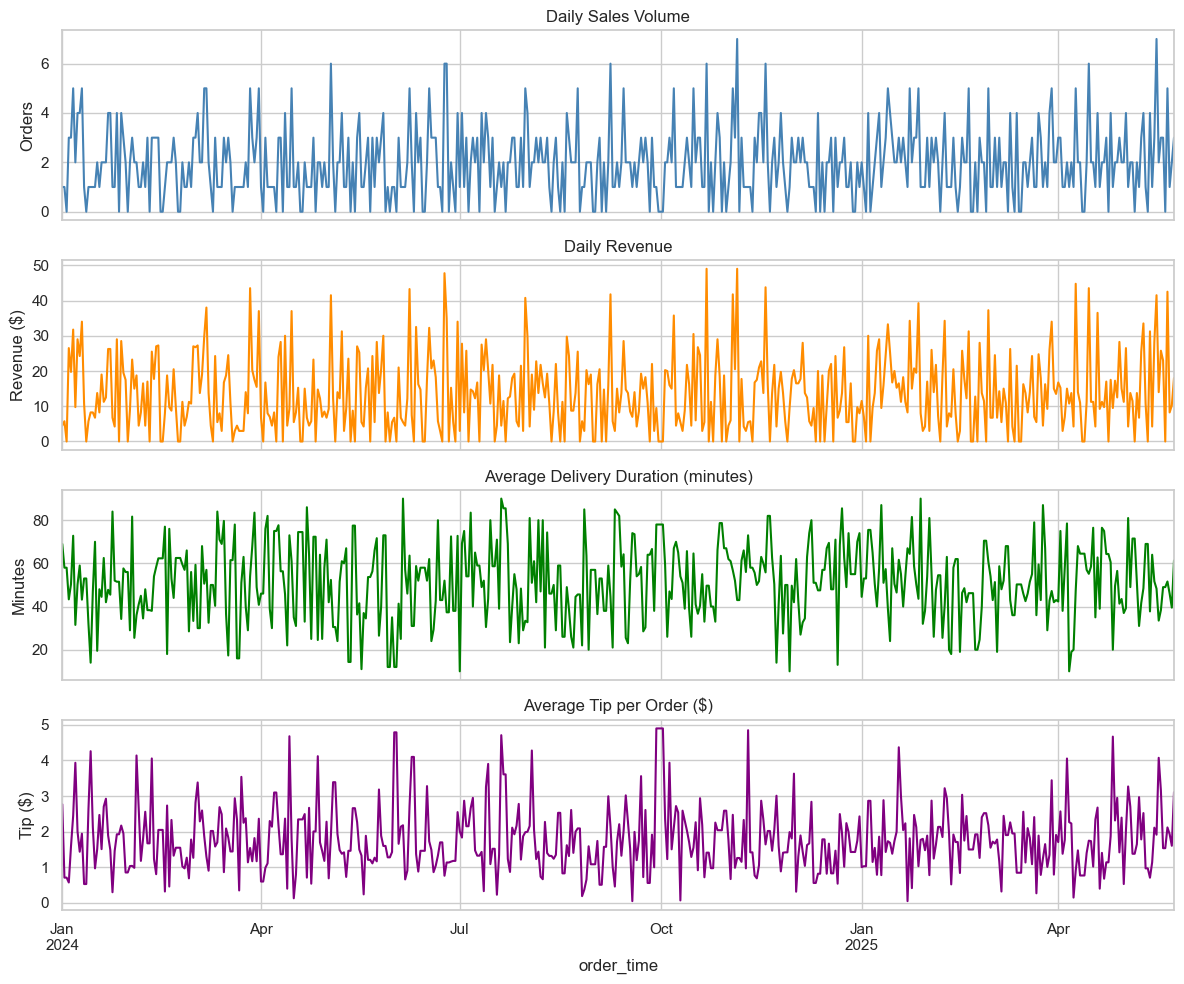

In [10]:
# 📊 Quick Trend Overview
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Daily Orders
daily["orders"].plot(ax=axes[0], label="Orders", color="steelblue")
axes[0].set_title("Daily Sales Volume")
axes[0].set_ylabel("Orders")

# Daily Revenue
daily["revenue"].plot(ax=axes[1], color="darkorange")
axes[1].set_title("Daily Revenue")
axes[1].set_ylabel("Revenue ($)")

# Average Delivery Duration
daily["avg_delivery_min"].plot(ax=axes[2], color="green")
axes[2].set_title("Average Delivery Duration (minutes)")
axes[2].set_ylabel("Minutes")

# Average Tip
daily["avg_tip"].plot(ax=axes[3], color="purple")
axes[3].set_title("Average Tip per Order ($)")
axes[3].set_ylabel("Tip ($)")

plt.tight_layout()
plt.show()


**📌 Interpretation**

- **Demand & Revenue** — Orders and revenue trends closely align, suggesting revenue is mainly volume-driven rather than price-driven. Peaks may correspond to promotions, weekends, or local events.

- **Operational Metrics** — Average delivery duration is fairly consistent but shows occasional spikes. These could result from driver shortages, weather, or high demand periods.

- **Tipping Behavior** — Average tips fluctuate more than orders or revenue. Sharp increases may reflect specific customer segments, delivery experiences, or promotional tipping nudges.


## 2.3 Rolling Averages & Seasonality

Daily sales and revenue often have high day‑to‑day variability due to promotions, weather, events, or random fluctuations.  
To reveal underlying trends and smooth out noise, we apply a **7‑day rolling mean** to both **orders** and **revenue**.

This also helps highlight:
- **Medium‑term demand shifts**
- **Seasonal cycles** (weekly patterns)
- **Anomalies worth investigating**


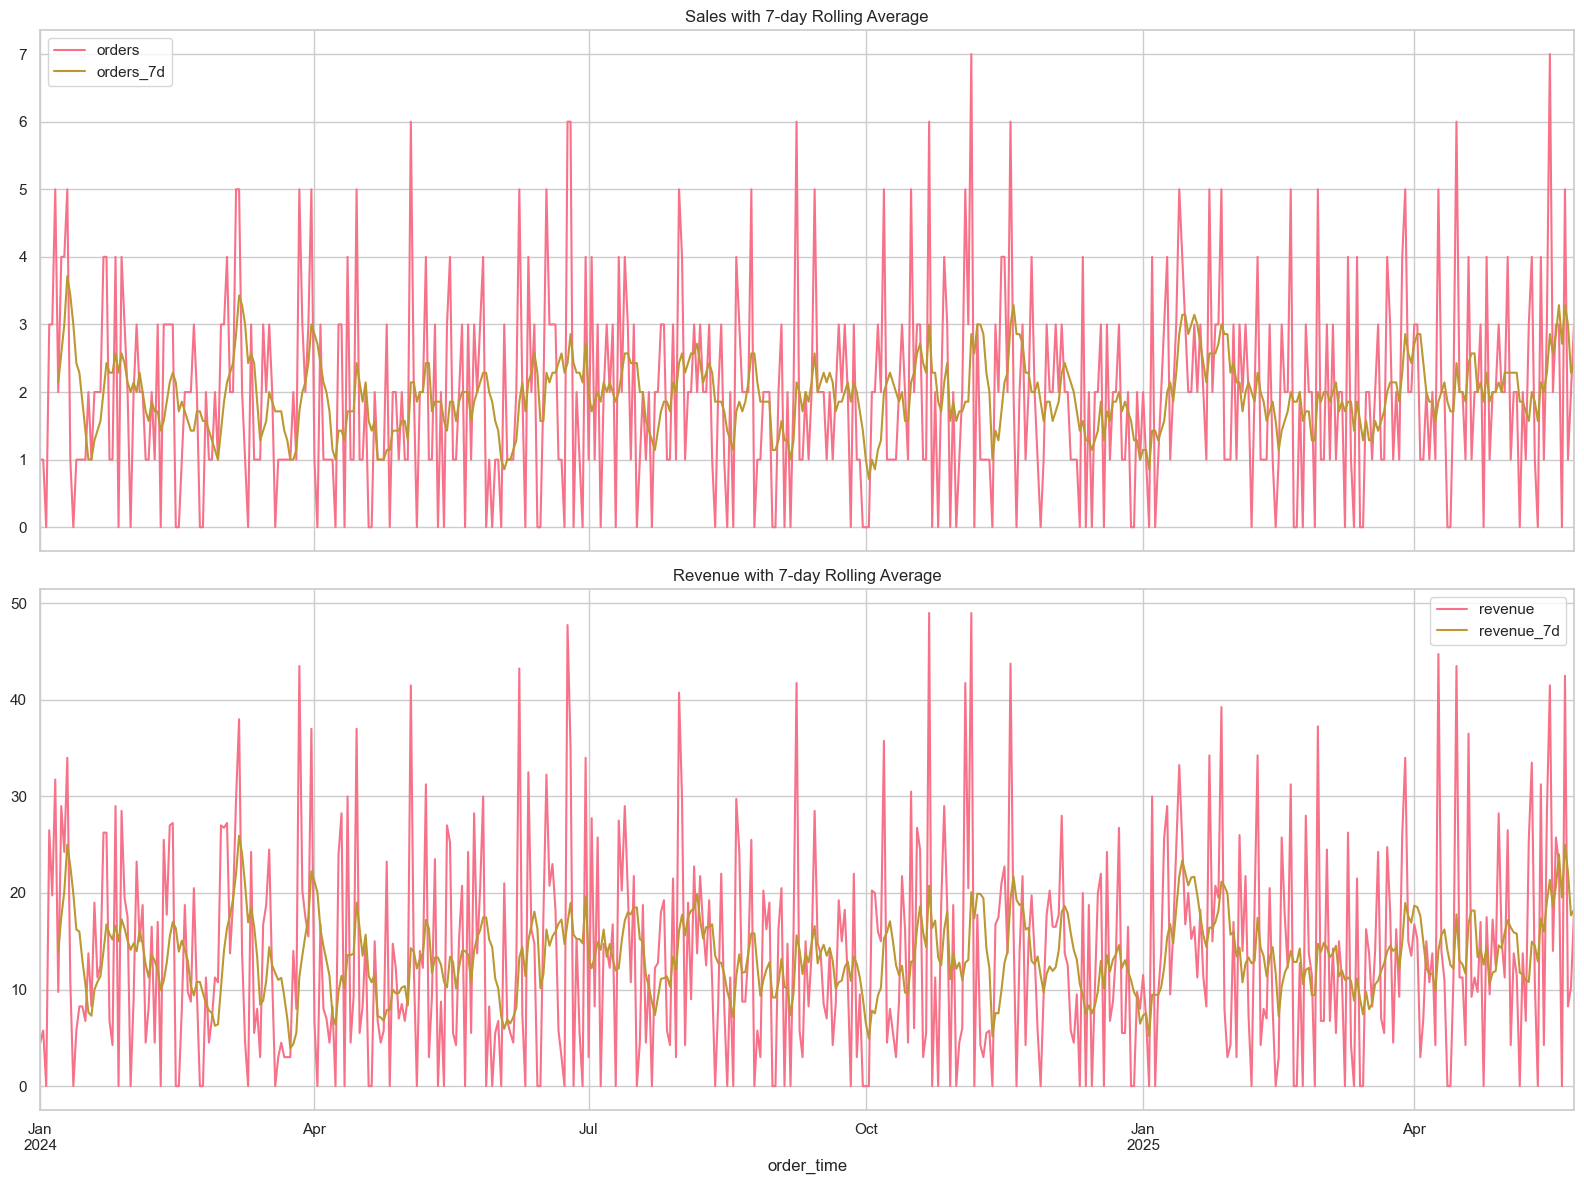

In [11]:

# 📆 Smooth daily noise with a 7-day rolling average

# Compute 7-day moving averages
daily["orders_7d"] = daily["orders"].rolling(7).mean()
daily["revenue_7d"] = daily["revenue"].rolling(7).mean()

# Plot sales and revenue trends
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Orders
daily[["orders", "orders_7d"]].plot(
    ax=axes[0],
    title="Sales with 7-day Rolling Average"
)

#Revenue
daily[["revenue", "revenue_7d"]].plot(
    ax=axes[1],
    title="Revenue with 7-day Rolling Average"
)

plt.tight_layout()
plt.show()


**📌 Interpretation**

The smoothed lines (**orange**) strip away daily volatility, making sustained growth or decline periods easier to spot.

Peaks in **orders** align closely with peaks in **revenue** → reinforces that revenue is volume‑driven.

Repeating wave‑like patterns every ~7 days hint at a strong **weekly seasonality**, useful for SARIMA or Prophet models.

Sharp divergences between raw and smoothed trends could indicate unusual events (e.g., campaign-driven spikes or weather-driven dips).

## 2.4 Day‑of‑Week Patterns

To uncover recurring weekly behaviors, we group sales data by the **day of the week**.  
This helps identify peak demand days and possible slumps where promotions or pricing changes could help.

**Steps:**  
- Calculate average **orders** and **revenue** per weekday  
- Visualize metrics using **bar charts** and **boxplots** to capture distributions and outliers


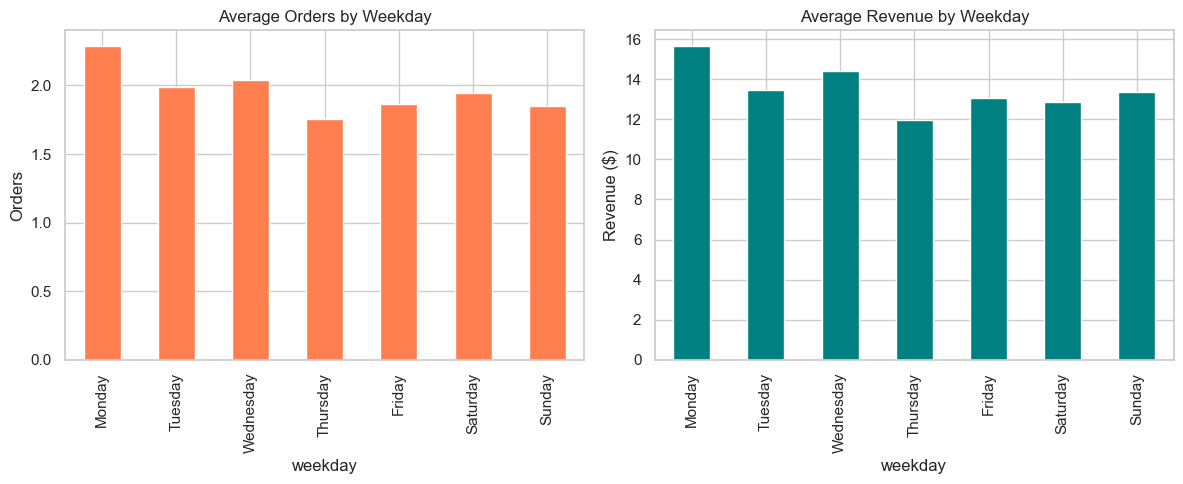

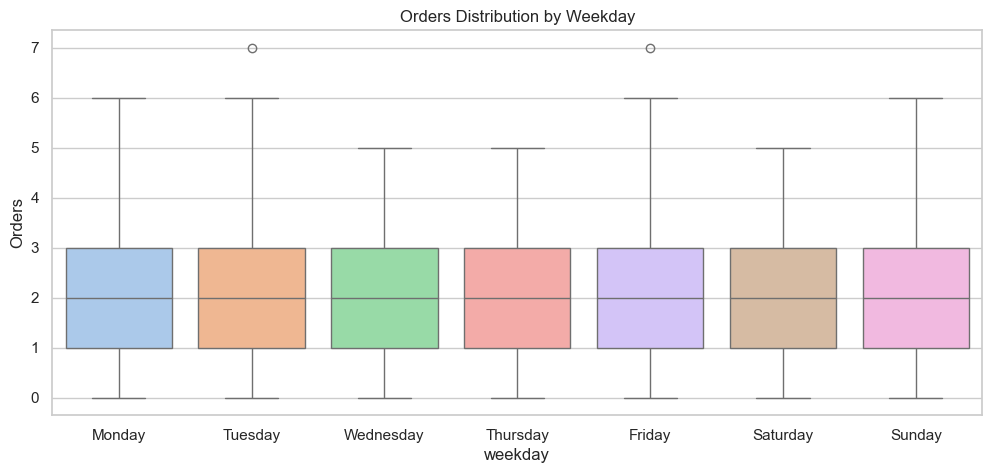

In [12]:
# 📊 Aggregate by day of week
daily["weekday"] = daily.index.day_name()

# Mean orders and revenue by weekday (ordered)
week_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
orders_by_weekday = daily.groupby("weekday")["orders"].mean().reindex(week_order)
revenue_by_weekday = daily.groupby("weekday")["revenue"].mean().reindex(week_order)

# Side-by-side bar charts
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
orders_by_weekday.plot(kind='bar', color="coral", ax=ax[0], title="Average Orders by Weekday")
ax[0].set_ylabel("Orders")
revenue_by_weekday.plot(kind='bar', color="teal", ax=ax[1], title="Average Revenue by Weekday")
ax[1].set_ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

# Box plot to show distribution and outliers
plt.figure(figsize=(12,5))
sns.boxplot(
    x="weekday", y="orders", data=daily,
    order=week_order, palette="pastel"
)
plt.title("Orders Distribution by Weekday")
plt.ylabel("Orders")
plt.show()

**📌 Interpretation**

- **Monday dominance** → Highest orders **~2.3/day** and revenue **~15.6 units/day**, making it a premium window for upsells or higher pricing.  
- **Thursday slump** → Orders and revenue dip notably → candidate for demand-boosting offers.  
- **Middle cluster (Tue, Wed, Fri, Sat, Sun)** → Fairly similar activity; promotions could be spread evenly or targeted to smooth Friday–Sunday variance.  

**Box plot insights:**  
- The **median is 2 orders/day across all weekdays**, showing stable central demand.  
- The **IQR (box) spans from 1 to 3 orders**, meaning most days fall within this narrow range.  
- The **whiskers extend from 0 up to 5–6 orders**, reflecting the usual spread of daily demand.  
- **Outliers** appear on **Tuesday and Friday** at 7 orders, indicating rare spikes likely tied to promotions, special events, or unusual customer activity.  

📌 Overall, the boxplots confirm that demand is generally consistent (2 orders/day typical), with occasional higher-order days that stand out as exceptions.  



## 2.5. Monthly Seasonality 

To spot broader seasonal demand shifts, we aggregate daily **orders** by calendar month.  
This helps guide **inventory planning, marketing campaigns, and staffing**.  

**Plots created:**  
- **Average Orders by Month** – shows typical demand levels per month  
- **Orders Distribution by Month** – shows variability and outliers



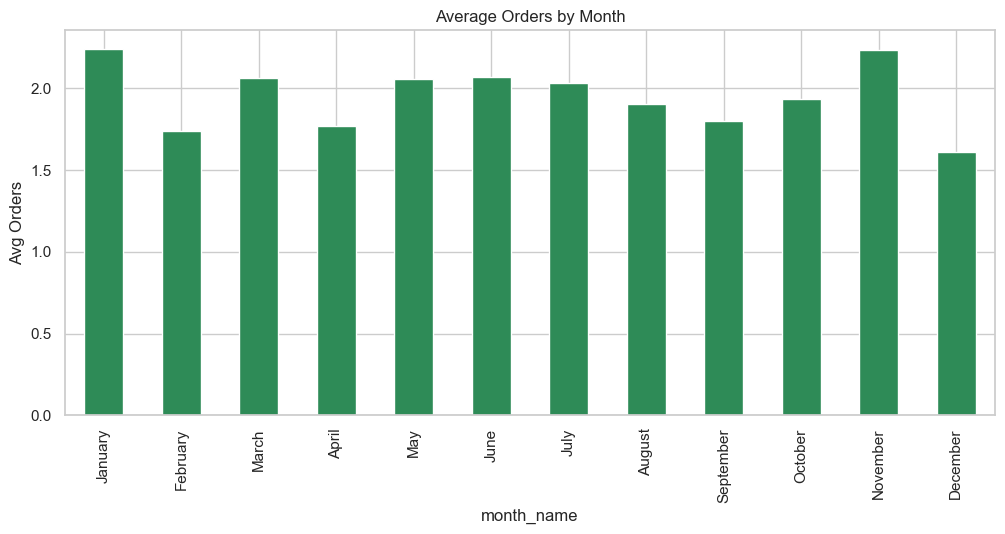

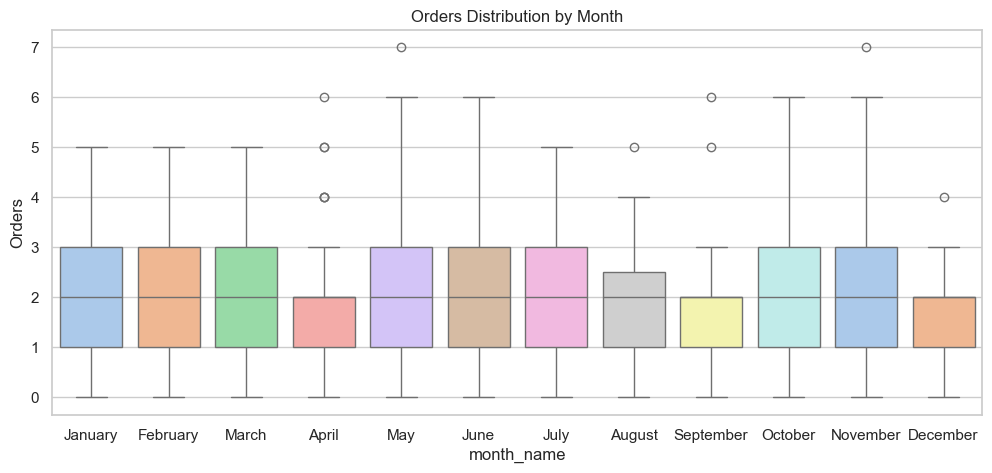

In [13]:

# 📅 Aggregate by month to check for seasonal demand
daily["month_name"] = daily.index.month_name()

# Compute mean orders per month (Jan–Dec order)
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
orders_by_month = daily.groupby("month_name")["orders"].mean().reindex(month_order)

# Bar chart – average orders per month
orders_by_month.plot(
    kind="bar", color="seagreen", figsize=(12,5), title="Average Orders by Month"
)
plt.ylabel("Avg Orders")
plt.show()

# Box plot – distribution of orders by month
plt.figure(figsize=(12,5))
sns.boxplot(
    x="month_name", y="orders", data=daily,
    order=month_order, palette="pastel"
)
plt.title("Orders Distribution by Month")
plt.ylabel("Orders")
plt.show()


**📌 Interpretation**

**Average Orders per Month**  
- The highest average demand occurs in **January (2.24)** and **November (2.23)**.  
- The lowest demand is in **December (1.61)** and **February (1.74)**.  
- Summer months (**June–August**) show moderate demand (~1.9–2.0).  

**Boxplot Interpretation**  
- For most months (**Jan, Feb, Mar, May, Jun, Jul, Oct, Nov**), the **median is 2 orders/day**, with boxes spanning **1–3** and whiskers extending **0–5 or 6** → indicating steady demand.  
- **April** and **September** show tighter boxes (**1–2**), with whiskers only up to **3**, but both have occasional **outliers at 4–6**, suggesting rare spikes.  
- **May** and **November** show **outliers at 7 orders**, reflecting rare but very high demand days.  
- **August** is similar to spring months, with whiskers up to **4** and an outlier at **5**.  
- **December** has a lower box (**1–2**) and whiskers only up to **3**, with outliers at **4**, confirming it as the lowest-demand month overall.  

📌 **Overall Insight:**  
- Demand is **consistently centered around 2 orders/day** throughout the year.  
- Occasional **outliers (5–7 orders)** appear in **spring, late summer, and fall**, likely tied to seasonal or promotional effects.  
- **January and November stand out as peak months**, while **December and February dip noticeably**, which may reflect holiday season slowdowns or customer behavior changes.  



## 2.6. Weekly Seasonality Analysis

We resample the daily dataset to **weekly frequency** to smooth daily volatility and better detect recurring patterns or annual cycles.  

**This step serves two purposes:**  
- **Weekly aggregation** — reduces random day-to-day noise while preserving seasonal signals.  
- **Seasonal decomposition** — isolates **trend**, **seasonality**, and **residual** components for model feature design.  


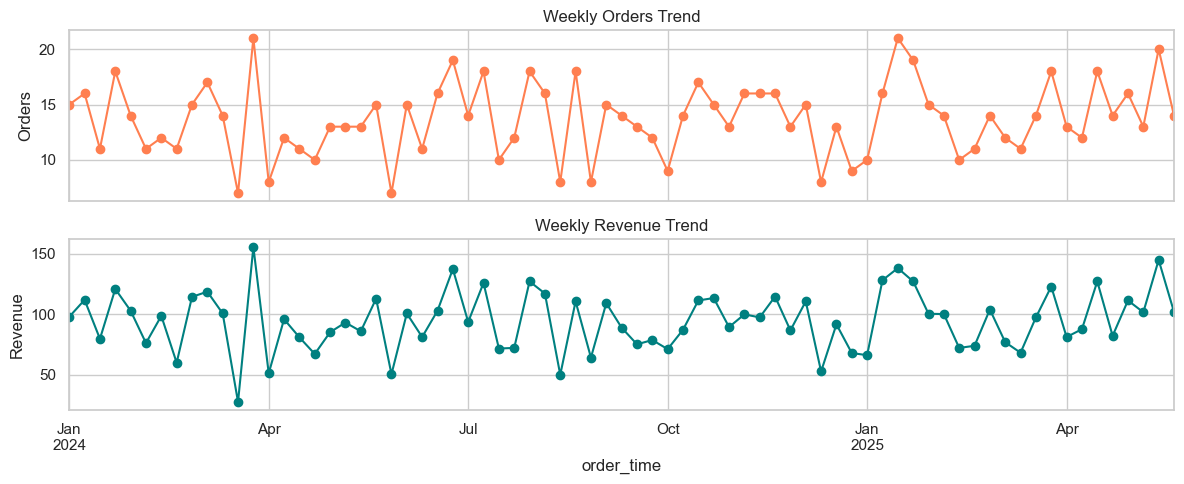

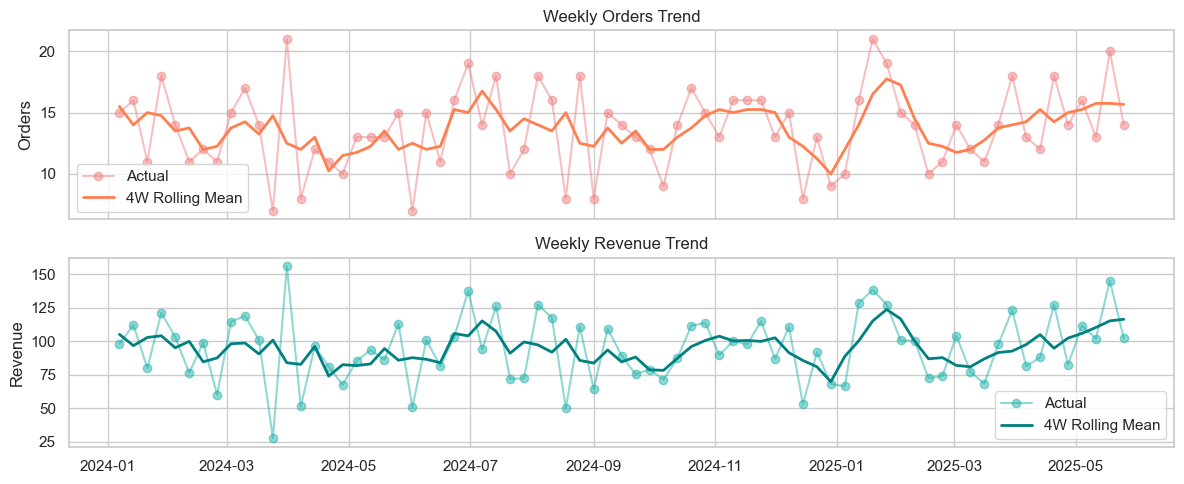

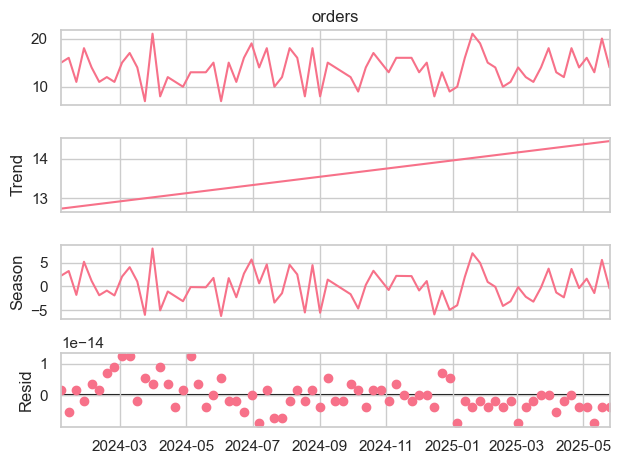

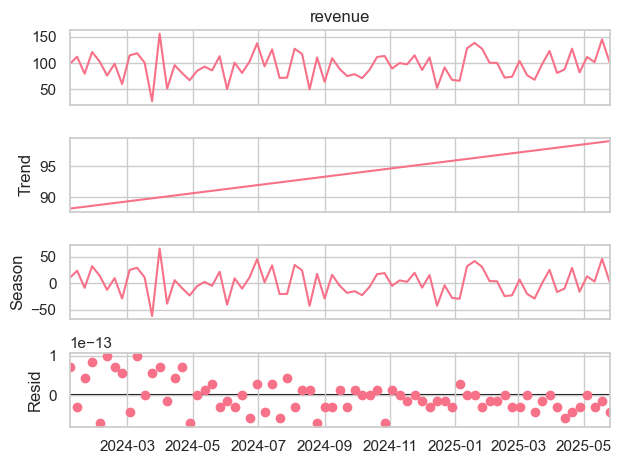

In [14]:
# 📆 Resample to Weekly Frequency
weekly = daily.resample('W').agg({
    'orders': 'sum',      
    'revenue': 'sum'      
})

# Initial weekly trend plots
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
weekly['orders'].plot(ax=ax[0], color='coral', marker='o', title='Weekly Orders Trend')
ax[0].set_ylabel('Orders')
weekly['revenue'].plot(ax=ax[1], color='teal', marker='o', title='Weekly Revenue Trend')
ax[1].set_ylabel('Revenue')
plt.tight_layout()
plt.show()

# 4-Week Rolling Mean Overlay
weekly['orders_roll'] = weekly['orders'].rolling(window=4, center=True, min_periods=1).mean()
weekly['revenue_roll'] = weekly['revenue'].rolling(window=4, center=True, min_periods=1).mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
# Orders
ax[0].plot(weekly.index, weekly['orders'], color='lightcoral', alpha=0.5, marker='o', label='Actual')
ax[0].plot(weekly.index, weekly['orders_roll'], color='coral', linewidth=2, label='4W Rolling Mean')
ax[0].set_title('Weekly Orders Trend')
ax[0].set_ylabel('Orders')
ax[0].legend()
# Revenue
ax[1].plot(weekly.index, weekly['revenue'], color='lightseagreen', alpha=0.5, marker='o', label='Actual')
ax[1].plot(weekly.index, weekly['revenue_roll'], color='teal', linewidth=2, label='4W Rolling Mean')
ax[1].set_title('Weekly Revenue Trend')
ax[1].set_ylabel('Revenue')
ax[1].legend()
plt.tight_layout()
plt.show()

# 🔍 Seasonal Decomposition (STL)
from statsmodels.tsa.seasonal import STL

# Approx 52 weeks in a year
stl_orders = STL(weekly['orders'], period=52)
res_orders = stl_orders.fit()
res_orders.plot()
plt.show()

stl_revenue = STL(weekly['revenue'], period=52)
res_revenue = stl_revenue.fit()
res_revenue.plot()
plt.show()


**📌 Interpretation**

- **Weekly aggregation** Orders and revenue show smoother patterns compared to daily data. Spikes are visible, likely due to promotions, events, or seasonal peaks. 
- **4-week rolling mean**  The smoothed line highlights the underlying trend, making periods of growth or decline easier to identify. Short-term volatility is reduced, while major peaks remain visible. 
- **STL Decomposition**:  
  - **Trend** — Gradual upward movement over the observed period. 
  - **Seasonal** — Clear cyclical pattern, consistent with annual/weekly seasonality.
  - **Residual** — Clear cyclical pattern, consistent with annual/weekly seasonality. 

Strong cyclical components suggest **weekly/annual seasonality** should be explicitly modeled in SARIMA seasonal order or Prophet’s yearly/weekly terms.


## 2.7. Price–Demand Relationship

We examine whether **average selling price** has a measurable relationship with **weekly orders**.

This check helps assess **price elasticity** — the degree to which demand changes when price changes.  
Elasticity ≈ %ΔOrders / %ΔPrice.


### 2.7.1 Visual Inspection
- Scatter plot to visualize how **order volume** varies across **average prices**.

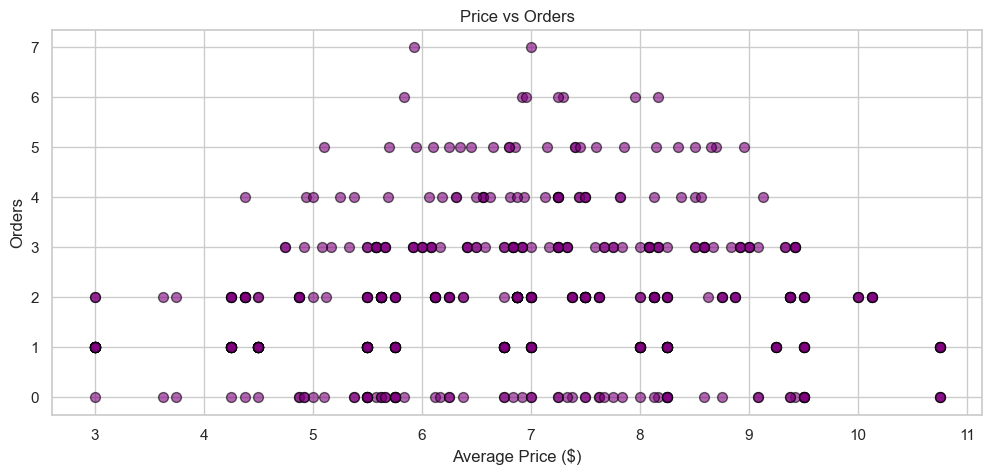

In [15]:
plt.figure(figsize=(12,5))
plt.scatter(daily['avg_price'], daily['orders'], alpha=0.6, color='purple', edgecolor='k', s=50)
plt.xlabel("Average Price ($)")
plt.ylabel("Orders")
plt.title("Price vs Orders")
plt.grid(True)
plt.show()


**📌 Interpretation**

- Most data points cluster around **$5–$9 average price** and **0–5 orders/day**.  
- Sparse data outside this price range means **extreme-price demand predictions may be less reliable**.  
- The scatter shows no strong linear relationship, suggesting demand is relatively inelastic within the observed price band.
- To confirm, a quick OLS or log‑log regression can estimate elasticity and test statistical significance.

### 2.7.2 Quick Elasticity Check (OLS)

We fit a **simple linear regression** to assess if **average price** significantly predicts **orders**.  

**Goal:** Quantify price elasticity approximately:  
**Elasticity ≈ %ΔOrders / %ΔPrice**  

- **Dependent variable (y):** orders  
- **Independent variable (X):** avg_price



In [16]:
import statsmodels.api as sm

X = sm.add_constant(daily['avg_price'])
y = daily['orders']

model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 orders   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     6.976
Date:                Thu, 25 Sep 2025   Prob (F-statistic):            0.00852
Time:                        15:17:45   Log-Likelihood:                -903.65
No. Observations:                 510   AIC:                             1811.
Df Residuals:                     508   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3216      0.250      5.284      0.0

**📌 Interpretation**

- **R² ≈ 0.014** → Price explains only ~1.4% of the variance in daily orders, indicating that price is not a strong predictor in this dataset. 
- **Coefficient for avg_price =0.0946 (p = 0.009)** → On average, each $1 increase in price is associated with ~0.095 more orders/day. This counter‑intuitive positive sign likely reflects reverse causality (prices nudged up on high‑demand days) rather than true price‑driven demand growth.
- **Conclusion:** At the aggregate level, **price is not the main driver of daily orders**.  
  - Demand fluctuations are dominated by **seasonality, day-of-week effects, and special events**, rather than price changes.  


## 2.8 Operational Metrics Analysis

Operational performance is a key driver of **customer satisfaction** and repeat business.  

**We analyze:**  
- **Average Delivery Time (minutes)** — indicates service speed  
- **Average Delivery Distance (km)** — shows delivery network reach  
- **Correlation Heatmap** — quantifies linear relationships between demand and operational metrics



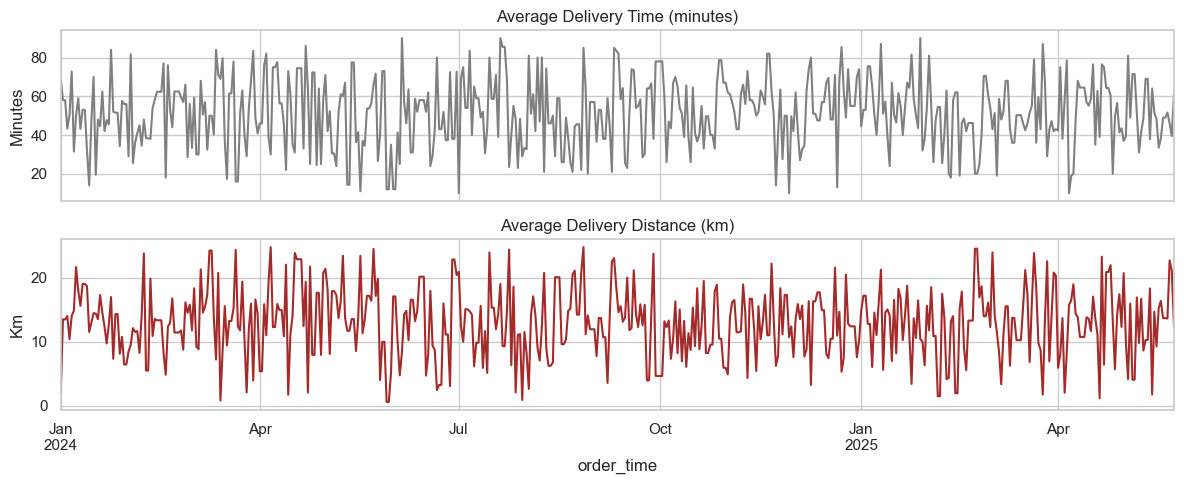

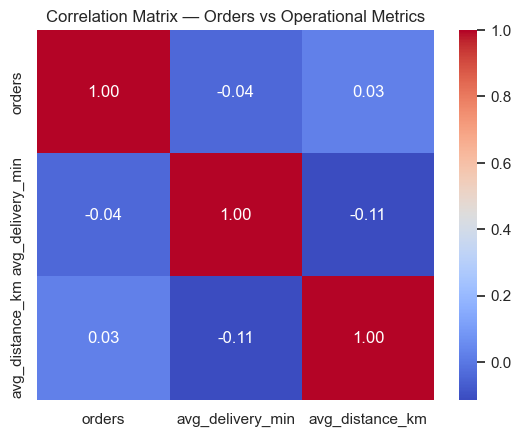

In [17]:

# 🚚 Delivery Performance Over Time
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

daily['avg_delivery_min'].plot(ax=ax[0], color='gray', title='Average Delivery Time (minutes)')
ax[0].set_ylabel("Minutes")
ax[0].grid(True)

daily['avg_distance_km'].plot(ax=ax[1], color='brown', title='Average Delivery Distance (km)')
ax[1].set_ylabel("Km")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 🔗 Correlation Analysis
corr_cols = ['orders','avg_delivery_min','avg_distance_km']
sns.heatmap(daily[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix — Orders vs Operational Metrics")
plt.show()


**📌 Interpretation**

**Delivery Time & Distance Trends:**  
- **Delivery Time:** Fluctuates between ~20–80 min with occasional spikes, but not meaningfully linked to order volume.
- **Delivery Distance:** Typically 0.5–25 km, also not meaningfully linked to order volume.

**Correlation Insights:**  All relationships are near zero (|r| < 0.11), suggesting that in this dataset, operational metrics are largely independent of daily demand.

**Business insight:** Since higher order volume isn’t currently slowing deliveries or extending distances, the delivery network appears to be scaling well under current demand levels.


## 2.9 Anomaly Detection

Identifying unusual spikes or drops in orders is crucial for diagnosing operational disruptions, marketing impacts, or unexpected demand shifts.

We detect anomalies in two complementary ways:
1. **Z‑Score Method (Daily level)** — flags days where order volume deviates more than ±3 standard deviations from the mean.
2. **STL Residuals (Weekly level)** — isolates irregular patterns after removing trend and seasonality.


,orders,avg_price,revenue,avg_tip,total_tip,avg_delivery_min,avg_distance_km,filled,was_missing,orders_7d,revenue_7d,weekday,month_name,orders_z
order_time,,,,,,,,,,,,,,
2024-11-05,7,7.000000,49.0,1.261429,8.83,43.000000,11.474286,False,False,2.857143,20.071429,Tuesday,November,3.513207
2025-05-16,7,5.928571,41.5,1.915714,13.41,48.285714,9.237143,False,False,2.857143,21.357143,Friday,May,3.513207


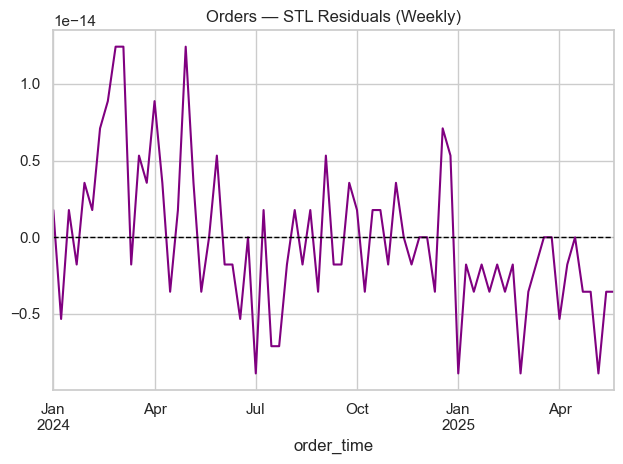

In [18]:
# ===============================
# 📈 1. Z-Score Based Outlier Detection
# ===============================
daily['orders_z'] = (daily['orders'] - daily['orders'].mean()) / daily['orders'].std()
outlier_days = daily[daily['orders_z'].abs() > 3]

display(outlier_days)

# ===============================
# 📊 2. STL Decomposition Residuals
# ===============================
weekly['orders_trend'] = res_orders.trend
weekly['orders_seasonal'] = res_orders.seasonal
weekly['orders_resid'] = res_orders.resid

weekly['revenue_trend'] = res_revenue.trend
weekly['revenue_seasonal'] = res_revenue.seasonal
weekly['revenue_resid'] = res_revenue.resid

weekly['orders_resid'].plot(
    title="Orders — STL Residuals (Weekly)", color="purple"
)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.tight_layout()
plt.show()


**📌 Interpretation**
1. **Z-Score on Orders (daily):** Flagged outliers beyond ±3σ.  
   - Notable spikes: **Nov 5, 2024** and **May 16, 2025**.  
2. **STL Residuals (weekly):**
- Mostly hover around zero, showing trend and seasonality explain most weekly order patterns.  
- Occasional spikes indicate rare demand anomalies.  
- **Forecasting implication:** Trend and seasonality dominate; irregular events are exceptions.
 

## 2.10 EDA Summary & Key Findings

**1️⃣ Demand Patterns**
- **Trend:** Upward trajectory into 2025.  
- **Seasonality:** Weekly peaks on Monday/Wednesday; monthly peaks in Jan (2.24) and Nov (2.23), lowest in Dec (1.61).  
- **Events:** Two exceptional spikes — Nov 5, 2024 & May 16, 2025 (~3.5σ above mean).  

**2️⃣ Price & Tips**
- **Price–Demand:** Scatter shows weak linear trend; OLS R² ≈ 0.014, coefficient +0.0946 (p=0.009), likely reverse causality.  
- **Tips:** Mostly stable; occasional outliers, not a strong demand driver.  

**3️⃣ Operational Metrics**
- **Delivery Time:** 20–80 min; occasional spikes.  
- **Delivery Distance:** 0.5–25 km; longer trips rare.  
- **Correlations:** Orders vs Time –0.04, Orders vs Distance +0.03 → negligible.  

**4️⃣ Anomalies**
- **Daily Z-Score:** Two days > +3σ (Nov 5, 2024; May 16, 2025).  
- **Weekly STL Residuals:** Notable deviations from seasonal trend.  

**📌 Forecasting Implications**
- **Seasonality & Trend:** Strong, suitable for SARIMA, Prophet, or ML models.  
- **Outliers:** Handle carefully (event indicators).  
- **Candidate Features:** Price, delivery metrics, tips, weekday/month, rolling stats.

---
# 3. 📈 Time Series Forecasting

## 3.1 Prepare the Time Series
- Weekly aggregation already done; seasonal/trend components engineered.
- Data clean and ready for modeling.

**Candidate Models:**

| Model          | Strengths                                        | Notes                                   |
|----------------|-------------------------------------------------|-----------------------------------------|
| SARIMA         | Captures seasonality, trend, autocorrelation   | Ideal for weekly patterns, needs stationarity |
| Prophet        | Handles holidays, changepoints, multiple seasonalities | Easy to tune, integrates with dashboards |
| XGBoost / RF   | Flexible for multivariate forecasting          | Use lag features + rolling stats         |


## 3.2. Check Stationarity

Many classical time series models (e.g., SARIMA) assume the series is **stationary** — its statistical properties (mean, variance, autocorrelation) do not change over time.

We check stationarity using two methods:
1. **Augmented Dickey–Fuller (ADF) Test** — statistical test for stationarity.
2. **Rolling Mean / Std Plot** — visual confirmation of stability.


=== Augmented Dickey-Fuller Test ===
ADF Statistic: -9.1138
p-value: 0.0000
Critical Value (1%): -3.5246
Critical Value (5%): -2.9026
Critical Value (10%): -2.5887
✅ Reject the null hypothesis — series is likely stationary.


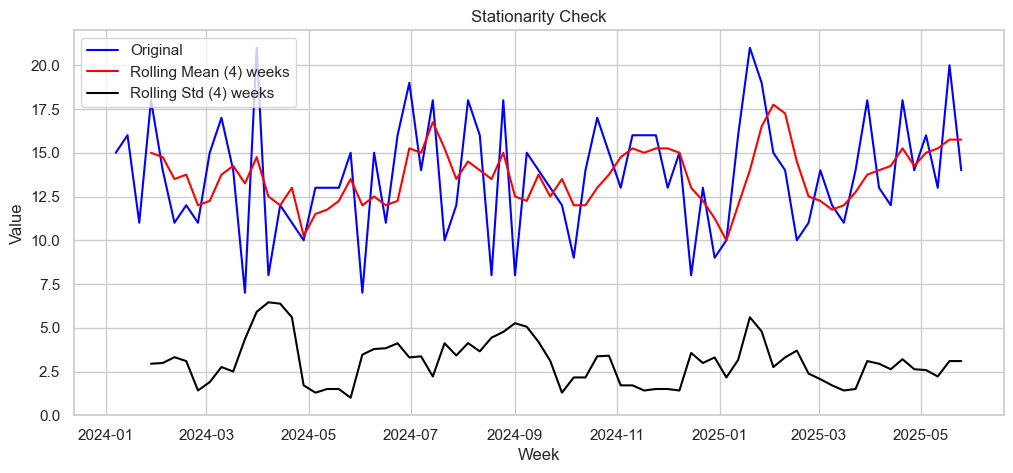

In [19]:
# 📊 Stationarity Check Function
def check_stationarity(series, window=4, title='Stationarity Check'):
    
    # --- 1. ADF Test ---
    result = adfuller(series.dropna())
    print("=== Augmented Dickey-Fuller Test ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    if result[1] <= 0.05:
        print("✅ Reject the null hypothesis — series is likely stationary.")
    else:
        print("⚠️ Fail to reject the null — series may be non-stationary.")

    # --- 2. Rolling Mean & Std ---
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 5))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label=f'Rolling Mean ({window}) weeks')
    plt.plot(rolling_std, color='black', label=f'Rolling Std ({window}) weeks')
    plt.title(title)
    plt.xlabel('Week')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Run stationarity check for weekly orders
check_stationarity(weekly['orders'], window=4)

**📌 Interpretation**

- **ADF Test:** p-value = 0.000 → series stationary  
- **Rolling Mean/Std:** Stable over time  

**Implications:**  
- SARIMA: Differencing not needed (d=0)  
- Prophet: Clean trend/seasonality separation  
- ML models: Stable variance improves lag/rolling features


## 3.3. Train/Test Split

- Cutoff: 2025-04-01
- Train: 65 weeks (Jan 2024 – Mar 2025)
- Test: 8 weeks (Apr – May 2025)


In [20]:
# ✂️ Train/Test Split

cutoff = '2025-04-01'
train = weekly[weekly.index < cutoff]
test = weekly[weekly.index >= cutoff]  

# Quick overview
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)


Training set shape: (65, 10)
Test set shape: (8, 10)


Plot the split to visually confirm the cutoff point:

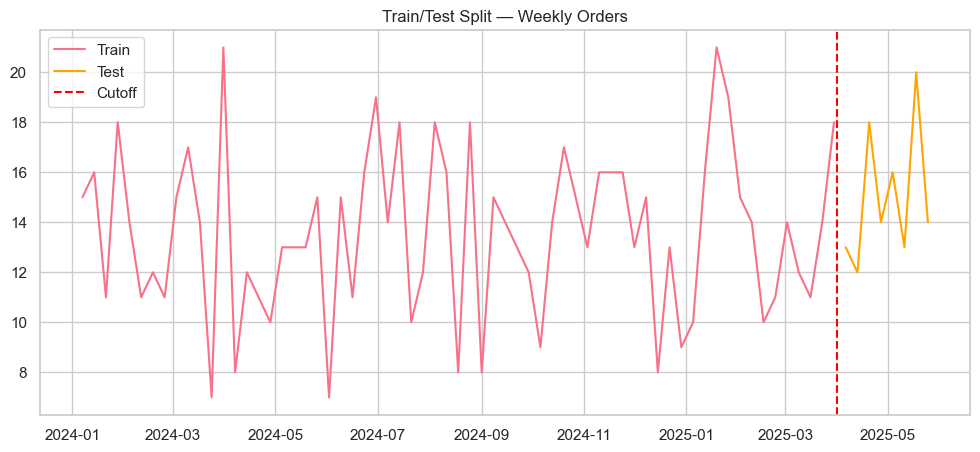

In [21]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train['orders'], label='Train')
plt.plot(test.index, test['orders'], label='Test', color='orange')
plt.axvline(pd.to_datetime(cutoff), color='red', linestyle='--', label='Cutoff')
plt.legend()
plt.title('Train/Test Split — Weekly Orders')
plt.show()


## 3.4. Traditional Model (SARIMA)

### 3.4.1 Fit SARIMA

**Chosen Parameters:** `(0,1,1)(1,0,0,52)`

**Non‑seasonal:**
- `d=1` → removes overall trend, stabilizes the mean.  
- `MA(1)` → captures short-term, one-week shocks remaining after differencing.

**Seasonal (annual, 52 weeks):**
- `P=1` → seasonal AR to model yearly recurrence.  
- `D=0` → yearly seasonality presumed stationary after non-seasonal differencing.

This configuration aims to capture weekly patterns while accounting for annual cycles in demand.

In [22]:
# Fit SARIMAX Model
sarima_model = SARIMAX(train['orders'], order=(0,1,1), seasonal_order=(1,0,0,52))
sarima_fit = sarima_model.fit(disp=False)

# Summary of model fit
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              orders   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -169.562
Date:                             Thu, 25 Sep 2025   AIC                            345.124
Time:                                     15:17:48   BIC                            351.601
Sample:                                 01-07-2024   HQIC                           347.676
                                      - 03-30-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     76.946     -0.013      0.990    -151.811     149.812
ar.S.L52       0.2567      

**📌 Interpretation of SARIMA Fit**

**Parameter Estimates:**

| Parameter | Coef     | Std Err | z-value | p-value | Notes |
|-----------|---------|---------|---------|---------|-------|
| ma.L1     | -1.0000 | 76.946  | -0.013  | 0.990   | Extremely high std. err → unstable estimate |
| ar.S.L52  | 0.2567  | 0.232   | 1.105   | 0.269   | Seasonal AR not statistically significant |
| sigma²    | 10.41   | 800.959 | 0.013   | 0.990   | High variance uncertainty |

**Fit Statistics:**
- Log Likelihood: -169.56  
- AIC: 345.12  
- BIC: 351.60  

**Diagnostics:**
- Ljung-Box p=0.49 → no major residual autocorrelation  
- Jarque-Bera p=0.79 → residuals roughly normal  

**Summary:**  
The model fits the data without major residual issues, but parameter estimates are unstable due to limited data points and high variance. Further tuning or alternative models may improve robustness.


### 3.4.2 SARIMA Forecast vs Test

We generate out-of-sample forecasts for the test period and compare them with actual weekly orders.

**Objectives:**
- Visualize how well SARIMA captures trends and seasonality.
- Assess forecast uncertainty using confidence intervals.


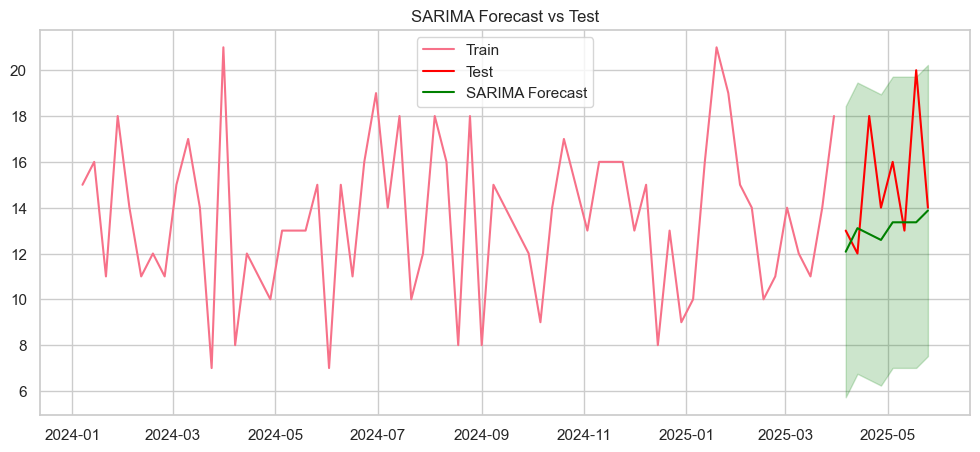

In [23]:

#  SARIMA Forecast + Confidence Intervals
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
sarima_preds = forecast_mean.values

plt.figure(figsize=(12,5))
plt.plot(train.index, train['orders'], label="Train")
plt.plot(test.index, test['orders'], label="Test", color="red")
plt.plot(test.index, forecast_mean, label="SARIMA Forecast", color="green")
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='green', alpha=0.2)
plt.title("SARIMA Forecast vs Test")
plt.legend()
plt.show()


**Visual Insights:**

**Visual Insights:**  
- **Forecast Shape:** SARIMA predicts a relatively flat trend with minor fluctuations over the 8-week horizon.  
- **Test Data:** Actual orders show an upward trend not fully captured by the model.  
- **Confidence Intervals:** Tight but may be unreliable due to parameter instability.  

**Model Limitations:**  
- Limited historical data (~1.25 years) reduces reliability of seasonal AR at lag 52.  
- Weak or inconsistent seasonality limits the explanatory power of the seasonal component.  
- Nonlinear effects (holidays, promotions) are outside SARIMA’s scope.  

**Implications:**  
- SARIMA serves as a simple baseline, capturing short-term dynamics and some seasonality.  
- It underfits upward trends and misses irregular spikes.  
- Comparison with flexible models (Prophet, RF/XGB) is recommended to improve accuracy.


## 3.5 Advanced Model: Prophet

### 3.5.1 Fit Prophet

- **Data frequency:** Weekly
- **Cutoff:** Training ends 2025‑04‑01; test covers Apr–May 2025 (8 weeks)
- **Seasonality:** `weekly_seasonality=True`: explicitly models day-of-week patterns
- **Future periods:** Forecast horizon matches test set length.

**Model Decomposition (internal):**

- **Trend** — long‑term growth/decline.
- **Seasonality** — repeating patterns (weekly in this config).
- **Holiday/Event effects** — none specified here, but can be added later.

**Purpose:** Fit Prophet to weekly orders to capture trend and weekly seasonal cycles, providing a flexible alternative to SARIMA for short-term forecasting.


In [24]:
# Prophet model
df_prophet = weekly.reset_index().rename(columns={'order_time': 'ds', 'orders': 'y'})
train_prophet = df_prophet[df_prophet['ds'] < cutoff]
test_prophet = df_prophet[df_prophet['ds'] >= cutoff]

# Fit Prophet model
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.fit(train_prophet)

# Create future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='W')
forecast_prophet = prophet_model.predict(future)

# Extract test set predictions
prophet_preds = forecast_prophet.set_index('ds').loc[test.index]['yhat']

15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing


### 3.5.2 Full Forecast with Historical Data

- **Full forecast** – predicted orders including historical training data.
- **Seasonality components** – trend, weekly, yearly (if enabled), to understand patterns captured by Prophet.


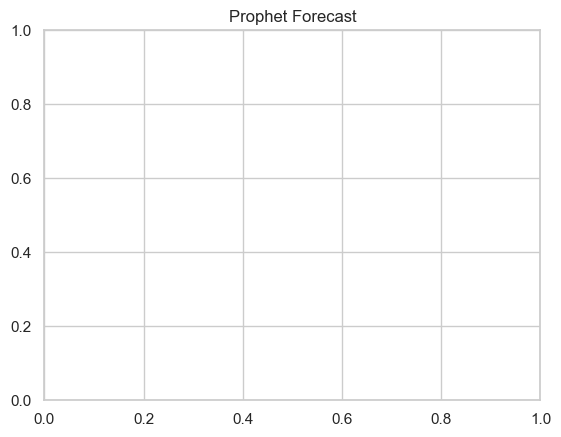

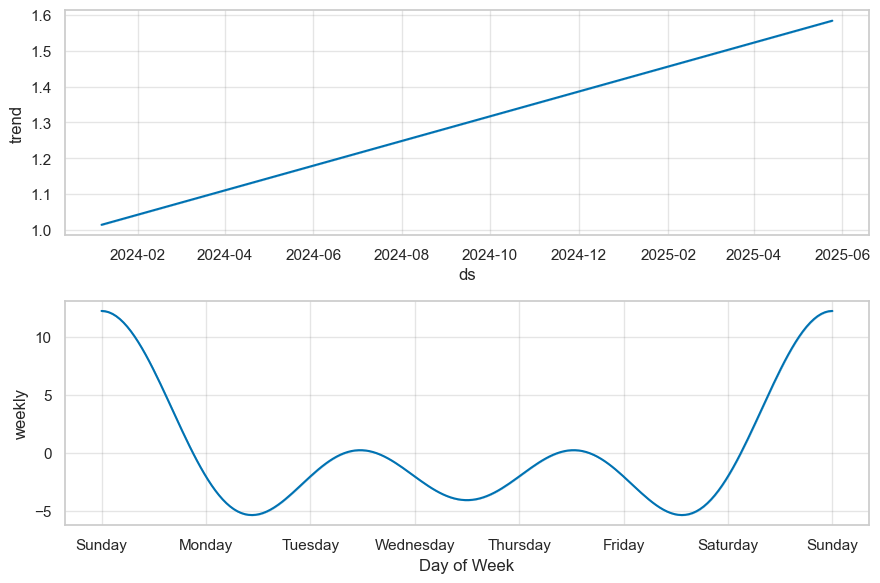

In [25]:
# fig1 = prophet_model.plot(forecast_prophet)
plt.title("Prophet Forecast")
plt.show()

fig2 = prophet_model.plot_components(forecast_prophet)
plt.show()

**Insights**

- **Forecast:** Gentle upward trend with weekly fluctuations; 95% confidence interval shown.  
- **Trend:** Steady growth from early 2024 to mid‑2025, capturing persistent demand increase.  
- **Weekly Seasonality:** Peaks on Sunday, troughs on Thursday; meaningful day-of-week variation.
.

### 3.5.3 Prophet Forecast vs Actuals

We compare Prophet predictions against the test set to evaluate how well the model captures recent demand:

- **Actual values** – weekly orders in the test set.
- **Forecast** – predicted orders (`yhat`) from Prophet.
- **Confidence intervals** – uncertainty range around the forecast.


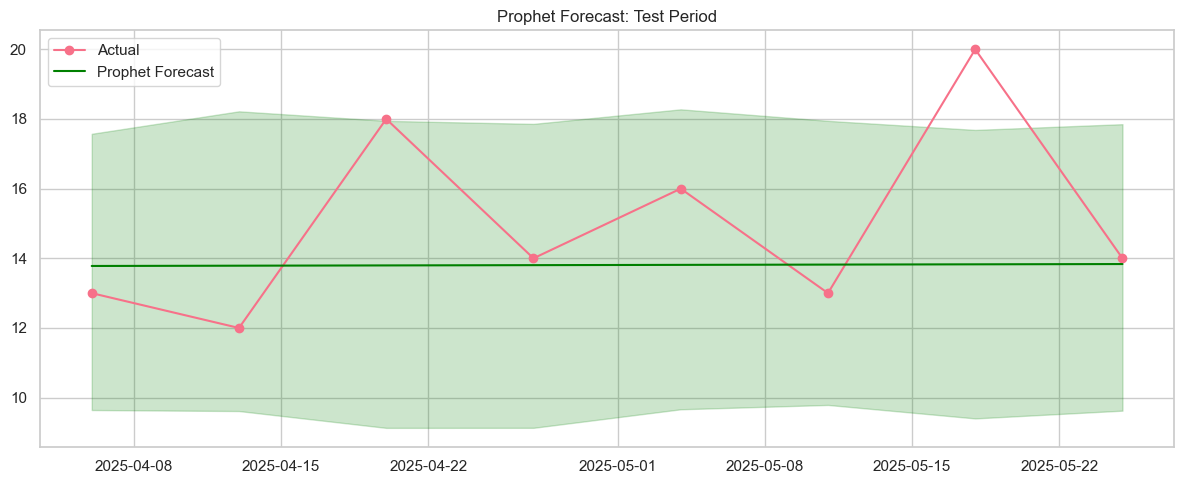

In [26]:
# Prophet forecast vs actuals
fig, ax = plt.subplots(figsize=(12, 5))

# Actual values
ax.plot(test.index, test['orders'], label='Actual', marker='o')

# Prophet forecast
ax.plot(prophet_preds.index, prophet_preds, label='Prophet Forecast', color='green')

# Confidence intervals
conf_int_prophet = forecast_prophet.set_index('ds').loc[test.index][['yhat_lower', 'yhat_upper']]
ax.fill_between(prophet_preds.index,
                conf_int_prophet['yhat_lower'],
                conf_int_prophet['yhat_upper'],
                color='green', alpha=0.2)

# Styling
ax.set_title('Prophet Forecast: Test Period')
ax.legend()
plt.tight_layout()
plt.show()



**Visual Insights**

- **Forecast shape:** Prophet’s forecast line (green) is almost flat, near 14 orders across the 8-week test period.  
- **Responsiveness:** The model stays close to the mean and does not capture week-to-week fluctuations.  
- **Actuals:** Test set values are volatile; highest spikes (18 and 20) occur later in the period.  
- **Confidence intervals:** Narrow and stable, reflecting low forecast volatility, but not capturing some peaks.  

**Implication:**  
Prophet acts as a “mean-level” forecaster. Useful for central tendency predictions, but underperforms for short-term spikes. To improve responsiveness, consider daily data or adding event/lag regressors.


## 3.6 Model Evaluation

We compare SARIMA and Prophet forecasts using standard metrics:

- **MAE (Mean Absolute Error):** Average absolute deviation between predicted and actual orders.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily.
- **MAPE (Mean Absolute Percentage Error):** Relative error(%), scale‑free comparison.
- **Bias:** Mean difference (predicted – actual); negative = under-forecasting.

In [27]:

# Model Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# SARIMA metrics
mae_sarima = mean_absolute_error(test['orders'], sarima_preds)
rmse_sarima = np.sqrt(mean_squared_error(test['orders'], sarima_preds))
mape_sarima = mean_absolute_percentage_error(test['orders'], sarima_preds) * 100
bias_sarima = (sarima_preds - test['orders']).mean()

# Prophet metrics
mae_prophet = mean_absolute_error(test['orders'], prophet_preds)
rmse_prophet = np.sqrt(mean_squared_error(test['orders'], prophet_preds))
mape_prophet = mean_absolute_percentage_error(test['orders'], prophet_preds) * 100
bias_prophet = (prophet_preds - test['orders']).mean()

# Display results
print("\n=== SARIMA Performance ===")
print(f"MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%, Bias: {bias_sarima:.2f}")

print("\n=== Prophet Performance ===")
print(f"MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, MAPE: {mape_prophet:.2f}%, Bias: {bias_prophet:.2f}")




=== SARIMA Performance ===
MAE: 2.29, RMSE: 3.20, MAPE: 13.54%, Bias: -1.93

=== Prophet Performance ===
MAE: 2.04, RMSE: 2.85, MAPE: 12.21%, Bias: -1.19


**📌 Interpretation**

| Metric | SARIMA | Prophet |
|--------|--------|---------|
| MAE    | 2.29   | 2.04    |
| RMSE   | 3.20   | 2.85    |
| MAPE   | 13.54% | 12.21%  |
| Bias   | -1.93  | -1.19   |

- **MAE / RMSE:** Prophet yields lower errors — more accurate forecasts.
- **MAPE:** Prophet achieves better relative accuracy.
- **Bias:** Both under-forecast, but Prophet is closer to actuals.

✅ -Prophet is the stronger baseline model for this dataset in terms of aggregate accuracy.  


## 3.7 Forecast Comparison

We compare **SARIMA** and **Prophet** forecasts against actual weekly orders.


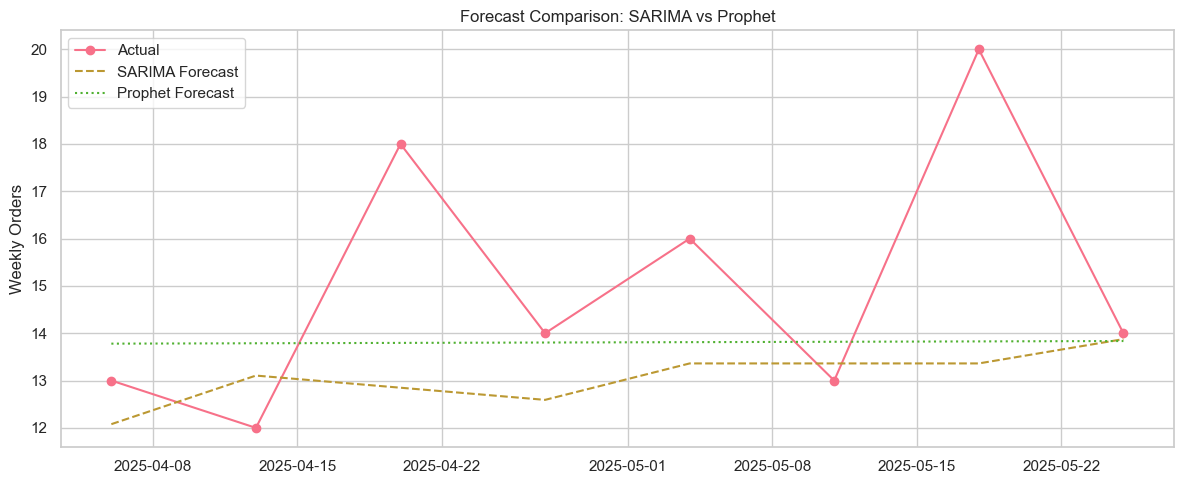

In [28]:

# Forecast Comparison Plot
plt.figure(figsize=(12, 5))

plt.plot(test.index, test['orders'], label='Actual', marker='o')
plt.plot(test.index, sarima_preds, label='SARIMA Forecast', linestyle='--')
plt.plot(test.index, prophet_preds, label='Prophet Forecast', linestyle=':')

plt.title('Forecast Comparison: SARIMA vs Prophet')
plt.ylabel('Weekly Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**📌 Visual Insights**

- **Actuals (pink):** Highly variable week-to-week; biggest spikes occur late in the test period. 
- **SARIMA (yellow dashed):** Starts near 12 orders, trends upward toward ~14. More responsive to late-period values but still misses the largest spikes.  
- **Prophet (green dotted):** Nearly flat around 14 orders, capturing the average level but not weekly fluctuations.  
- **Responsiveness:** SARIMA reacts slightly more to short-term changes than Prophet.  

**Implication**
- **Prophet:** Strong at holding the mean level → useful for stable, central-tendency forecasts.  
- **SARIMA:** Better at short-term adjustments → useful if responsiveness is valued.  
- **Choice:** Depends on business needs — **stability** vs **reactivity**.

## 3.8. Residual Analysis
After fitting both SARIMA and Prophet, residuals (actual – predicted) were compared to evaluate forecast accuracy beyond aggregate metrics.

### 3.8.1. Define Compare Dataframe
A combined DataFrame was created containing:
- Actual values for the test set.
- Model predictions for SARIMA and Prophet.
- Residuals for each model (`Actual – Predicted`).

In [29]:
df_compare = pd.DataFrame({
    'SARIMA_Actual': test['orders'].values,
    'SARIMA_Predicted': sarima_preds,
    'SARIMA_Error': test['orders'].values - sarima_preds,
    'Prophet_Actual': test_prophet['y'].values,
    'Prophet_Predicted': prophet_preds.values,
    'Prophet_Error': test_prophet['y'].values - prophet_preds.values
})

### 3.8.2. Residual distributions

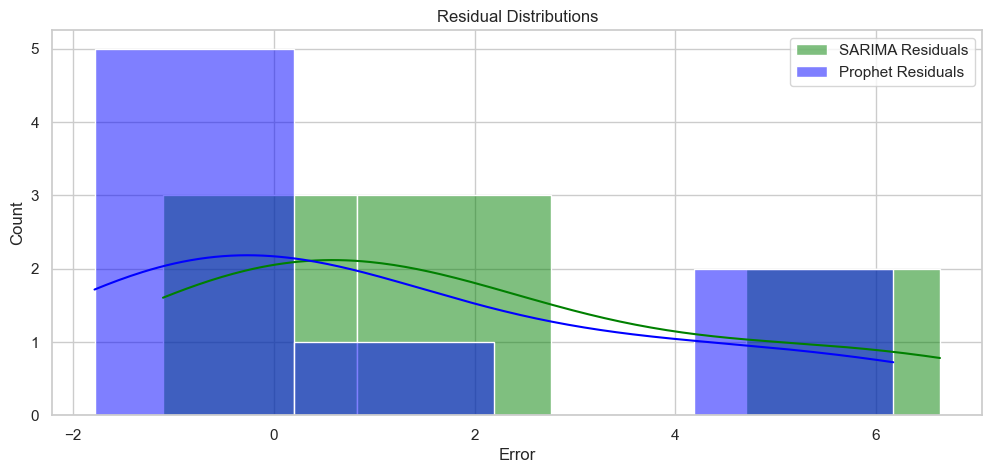

In [30]:
# Residual distributions
plt.figure(figsize=(12,5))
sns.histplot(df_compare['SARIMA_Error'], kde=True, color='green', label="SARIMA Residuals", alpha=0.5)
sns.histplot(df_compare['Prophet_Error'], kde=True, color='blue', label="Prophet Residuals", alpha=0.5)
plt.title("Residual Distributions")
plt.xlabel('Error')
plt.legend()
plt.show()


**Visual Insights:**
- **Centering:** Both models’ residuals are centered around zero, indicating no extreme systematic bias.
- **Spread:** Prophet’s residual distribution is **narrower**, suggesting lower variance in errors.
- **Shape:** Prophet’s residuals are more tightly clustered, while SARIMA’s are more spread out, reflecting greater week‑to‑week deviation from actuals.

### 3.8.3 Residuals Over Time

Plotting residuals helps identify periods where models consistently under- or over-predict.  
Residuals closer to zero with smaller fluctuations indicate a better fit.


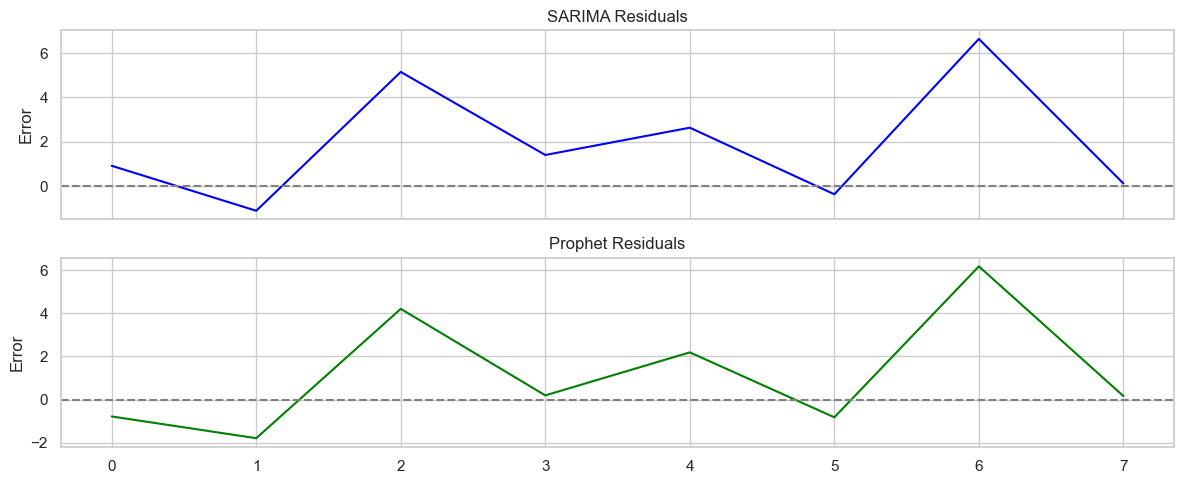

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

# SARIMA residuals
axes[0].plot(df_compare.index, df_compare['SARIMA_Error'], color='blue')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].set_title('SARIMA Residuals')
axes[0].set_ylabel('Error')

# Prophet residuals
axes[1].plot(df_compare.index, df_compare['Prophet_Error'], color='green')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Prophet Residuals')
axes[1].set_ylabel('Error')

plt.tight_layout()
plt.show()


**Residual Interpretation**
The residual time series compares errors from SARIMA (top) and Prophet (bottom).  
- **SARIMA residuals** fluctuate more widely, with large positive spikes, suggesting frequent underprediction and higher variance.  
- **Prophet residuals** are closer to zero and more balanced between positive and negative values, though some spikes remain.  
Overall, Prophet shows more stable and less biased predictions compared to SARIMA.


### 3.8.4 Autocorrelation Function (ACF) of Residuals

ACF plots reveal whether residuals are correlated over time. Ideally, residuals should resemble white noise (no autocorrelation).


<Figure size 1200x500 with 0 Axes>

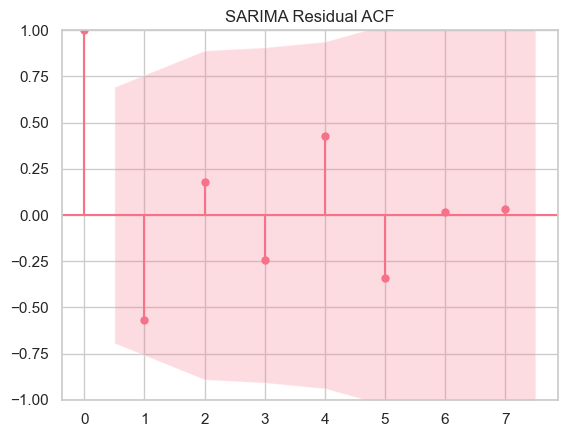

<Figure size 1200x500 with 0 Axes>

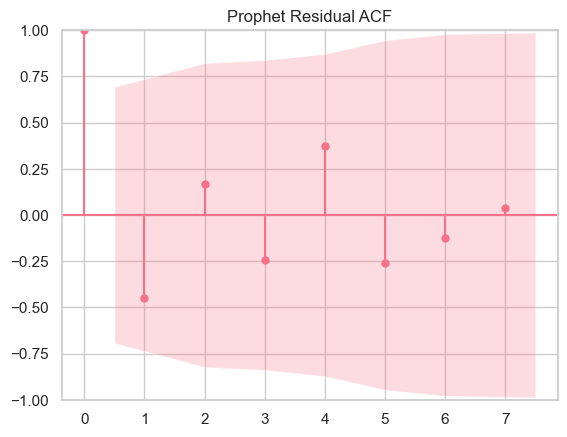

In [32]:

plt.figure(figsize=(12,5))
plot_acf(df_compare['SARIMA_Error'].dropna(), lags=7)
plt.title("SARIMA Residual ACF")
plt.show()

plt.figure(figsize=(12,5))
plot_acf(df_compare['Prophet_Error'].dropna(), lags=7)
plt.title("Prophet Residual ACF")
plt.show()


**🔎 Residual ACF Interpretations**

The ACF plots show that residuals from both SARIMA and Prophet mostly fall within the confidence bands, indicating no strong autocorrelations.  
- **SARIMA** shows a small spike around lag 4, but it is not strongly significant.  
- **Prophet** has a similar weak spike, slightly smaller in magnitude.  
Overall, both models produce residuals that resemble white noise, suggesting they capture the main data patterns well.



## 3.9 Future Forecast (Next 8 Weeks)

After validating SARIMA and Prophet, both models were projected 8 weeks ahead to assess near-term demand.


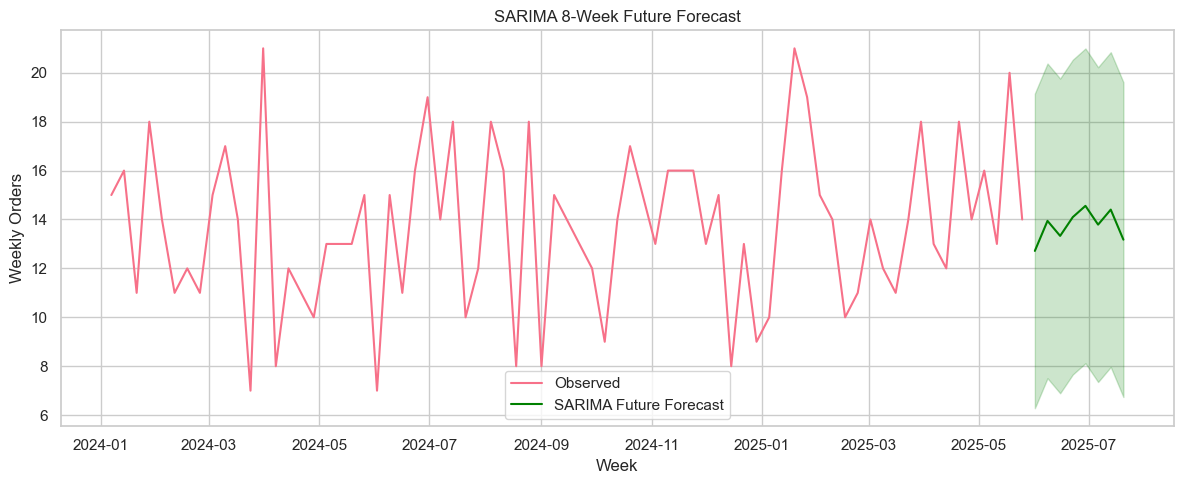

15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing


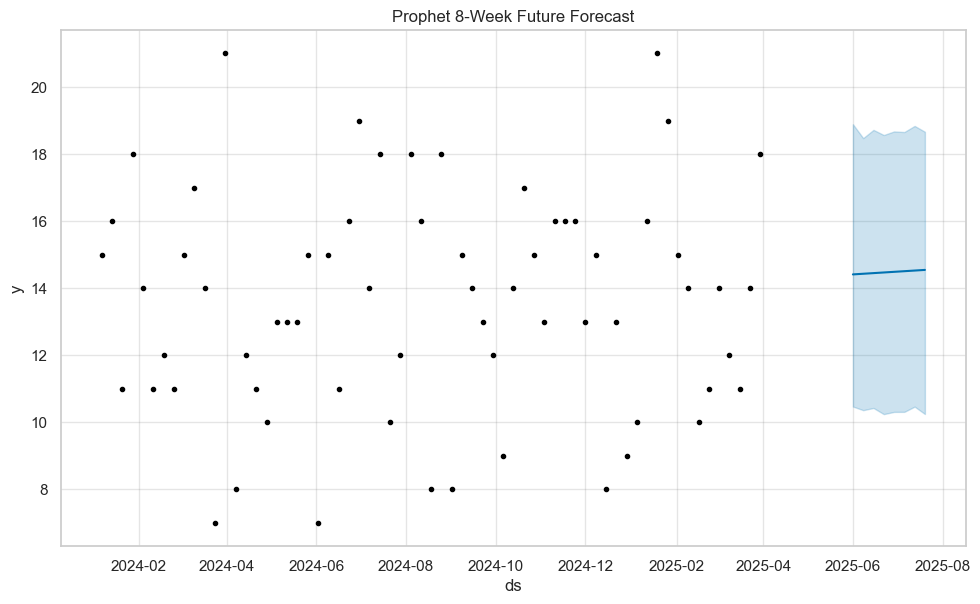

In [33]:
steps_ahead = 8
# Extend training to include test period
extended_train = weekly[weekly.index <= pd.to_datetime("2025-05-25")]
sarima_fit_extended = SARIMAX(extended_train['orders'], order=(0,1,1), seasonal_order=(1,0,0,52)).fit()
# ===============================
# SARIMA Future Forecast
# ===============================
forecast_future = sarima_fit_extended.get_forecast(steps=steps_ahead)
sarima_future_preds = forecast_future.predicted_mean
conf_int_future = forecast_future.conf_int()
future_dates = pd.date_range(weekly.index[-1], periods=steps_ahead+1, freq='W')[1:]

plt.figure(figsize=(12,5))
plt.plot(weekly.index, weekly['orders'], label="Observed")
plt.plot(future_dates, sarima_future_preds, label="SARIMA Future Forecast", color="green")
plt.fill_between(future_dates, conf_int_future.iloc[:,0], conf_int_future.iloc[:,1], color='green', alpha=0.2)
plt.title("SARIMA 8-Week Future Forecast")
plt.xlabel("Week")
plt.ylabel("Weekly Orders")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# Prophet Future Forecast
# ===============================
# Re-instantiate Prophet
prophet_model_extended = Prophet(weekly_seasonality=True)

# Extend training to include test period
train_prophet_extended = df_prophet[df_prophet['ds'] <= pd.to_datetime("2025-05-25")]

# Fit on extended training data (up to May 25, 2025)
prophet_model_extended.fit(train_prophet_extended)

# Generate future dates starting after May 25
future_extended = prophet_model_extended.make_future_dataframe(periods=8, freq='W')
future_extended = future_extended[future_extended['ds'] > pd.to_datetime("2025-05-25")]

# Forecast
forecast_prophet_extended = prophet_model_extended.predict(future_extended)
prophet_future_preds = forecast_prophet_extended.set_index('ds')['yhat']

fig = prophet_model.plot(forecast_prophet_extended)
plt.title("Prophet 8-Week Future Forecast")
plt.show()


**📌 Interpretation**

**SARIMA:**
- Projects a **mild upward slope** from the last observed point.
- Confidence intervals are **wider**, indicating greater uncertainty.
- More sensitive to recent fluctuations, but less smooth.

**Prophet:**
- Shows a **slightly upward trend** rather than a flat line, influenced by recent positive movement in the data.
- Confidence intervals are **narrower** and stable, suggesting higher certainty in the central forecast.
- Seasonal effects are smoothed due to weekly aggregation; daily‑level modeling could enhance responsiveness.

**Trend Expectation:**
- Both models predict **stable to slightly increasing** weekly orders over the next 8 weeks.
- No large deviations are expected without external events.


## 3.10. ML-Based Forecasting (Random Forest & XGBoost)

### 3.10.1 Feature Engineering

To capture both short-term dependencies and long-term seasonalities, we engineered the following features:

- **Lag features:**
- `lag_1`, `lag_2`, `lag_3`: Orders from 1–3 weeks.  
- `lag_52`: Orders from same week in the prior year (seasonality anchor).  
- **Calendar features:**
-  `weekofyear`, `month`, `year`: Capture seasonal cycles.  
- `is_weekend`: 1 if Sat/Sun, else 0.
- 
These features provide context about **recent demand** and **recurring seasonal patterns**.


In [34]:
# target column 
target_col = "orders"

# Function to create lag features
def create_lag_features(df, target_col, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

# Apply lag features
weekly_ml = create_lag_features(weekly.copy(), target_col, lags=[1, 2, 3, 52])

# ===============================
# Calendar / Time Features
# ===============================
weekly_ml['weekofyear'] = weekly_ml.index.isocalendar().week
weekly_ml['month'] = weekly_ml.index.month
weekly_ml['year'] = weekly_ml.index.year
weekly_ml['is_weekend'] = (weekly_ml.index.weekday >= 5).astype(int)

# Inspect engineered features
weekly_ml.head()


,orders,revenue,orders_roll,revenue_roll,orders_trend,orders_seasonal,orders_resid,revenue_trend,revenue_seasonal,revenue_resid,lag_1,lag_2,lag_3,lag_52,weekofyear,month,year,is_weekend
order_time,,,,,,,,,,,,,,,,,,
2024-01-07,15,98.00,15.50,105.000000,12.741844,2.258156,1.776357e-15,88.212380,9.787620,7.105427e-14,NaN,NaN,NaN,NaN,1,1,2024,1
2024-01-14,16,112.00,14.00,96.583333,12.765555,3.234445,-5.329071e-15,88.361839,23.638161,-2.842171e-14,15.0,NaN,NaN,NaN,2,1,2024,1
2024-01-21,11,79.75,15.00,102.687500,12.789265,-1.789265,1.776357e-15,88.511299,-8.761299,4.263256e-14,16.0,15.0,NaN,NaN,3,1,2024,1
2024-01-28,18,121.00,14.75,103.937500,12.812975,5.187025,-1.776357e-15,88.660758,32.339242,8.526513e-14,11.0,16.0,15.0,NaN,4,1,2024,1
2024-02-04,14,103.00,13.50,95.000000,12.836686,1.163314,3.552714e-15,88.810218,14.189782,-7.105427e-14,18.0,11.0,16.0,NaN,5,2,2024,1


### 3.10.2 Train/Test Split

To prevent data leakage, we used a **time-aware split**:

- **Train set:** Data up to 2025-03-31 → used for model fitting.
- **Test set:** Data from 2025-04-01 onward → used for evaluation.
- Drop initial rows with `NaN` lag values before training.

This ensures the models only learn from past information and are evaluated on future, unseen weeks.


In [35]:

# Time-Aware Train/Test Split
train_ml = weekly_ml.loc[:'2025-03-31'].dropna()  # drop rows with NaNs from lag features
test_ml = weekly_ml.loc['2025-04-01':]

# Features and target
X_train = train_ml.drop(columns=['orders'])
y_train = train_ml['orders']

X_test = test_ml.drop(columns=['orders'])
y_test = test_ml['orders']

# Inspect shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (13, 17), y_train: (13,)
X_test: (8, 17), y_test: (8,)


### 3.10.3 Machine Learning Forecasting

**Goal:** Train and compare Random Forest and XGBoost regressors using lagged and calendar features.

**Evaluation Metrics:**

- **MAE** — Mean Absolute Error
- **RMSE** — Root Mean Squared Error
- **MAPE (%)** — Mean Absolute Percentage Error

These metrics allow direct comparison with SARIMA and Prophet, and highlight the benefit of nonlinear, multivariate learning.

In [36]:
# Model Training & Evaluation
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
    return {"Model": name, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

results = []

# Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
results.append(evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test))

# XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
results.append(evaluate_model("XGBoost", xgb, X_train, y_train, X_test, y_test))

# Compare
metrics_rf_xgb = pd.DataFrame(results)
print(metrics_rf_xgb)


           Model       MAE      RMSE  MAPE (%)
0  Random Forest  1.013750  1.081385  6.702094
1        XGBoost  0.871436  0.948963  5.954382


**📌 Interpretation**

| Model         | MAE    | RMSE   | MAPE (%) |
|---------------|--------|--------|----------|
| Random Forest | 1.01   | 1.08   | 6.70     |
| XGBoost       | 0.87   | 0.95   | 5.95     |

- **XGBoost outperforms Random Forest** across all metrics.
- Both ML models achieve lower errors than SARIMA and Prophet, thanks to lag features and calendar variables.
- **MAPE < 6%** indicates highly accurate short-term forecasts.


### 3.10.4 Feature Importance Analysis

**Goal:** Identify which features most influence XGBoost predictions to confirm the model captures meaningful patterns.


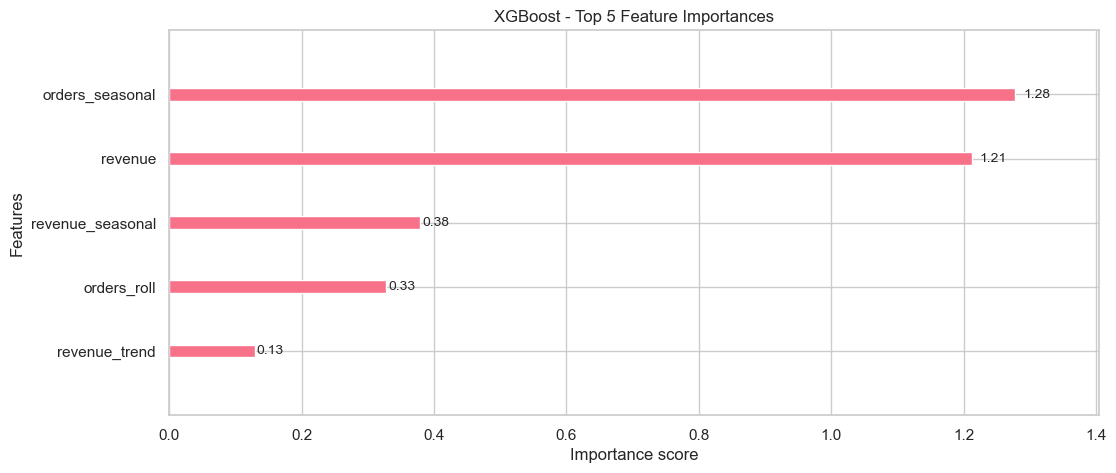

In [37]:

# XGBoost Feature Importance

# Plot top 5 features without default labels
fig, ax = plt.subplots(figsize=(12,5))
plot_importance(xgb, max_num_features=5, importance_type='gain', ax=ax, show_values=False)
plt.title("XGBoost - Top 5 Feature Importances")


for p in ax.patches:
    width = p.get_width()
    ax.text(width + width*0.01, p.get_y() + p.get_height()/2,
            f'{width:.2f}', va='center', ha='left', fontsize=10)

plt.show()



**📌 Interpretation**

- **orders_seasonal** and **revenue** dominate, confirming that seasonality and total demand levels are the strongest drivers.

- **revenue_seasonal** and **orders_roll** show the model also leverages cyclical variation and short-term smoothing.

- **revenue_trend** plays a smaller role but still contributes to capturing the overall direction of demand.

✅ This ranking confirms XGBoost is learning meaningful **seasonality, recency, and trend patterns** rather than noise.

### 3.10.5. Plot Predictions vs Actuals (Time Series Check)

We compare actual taco sales against Random Forest and XGBoost predictions to visually assess model performance over the test period.

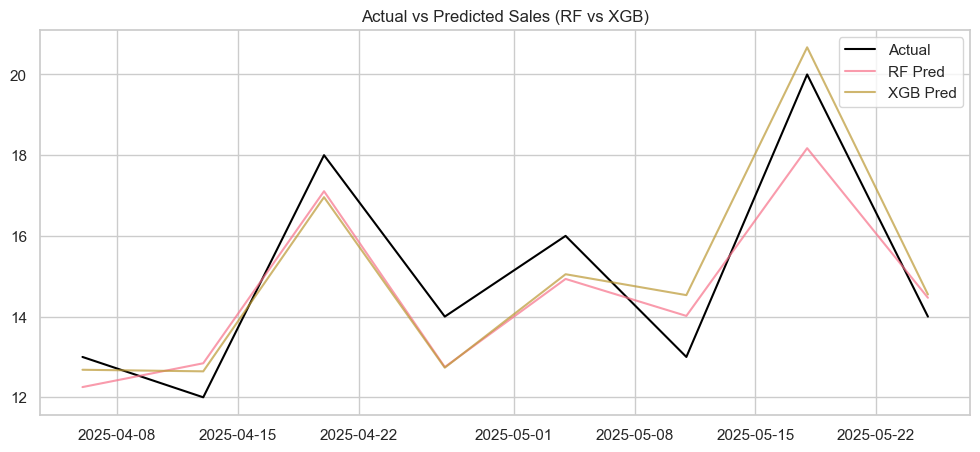

In [38]:
# Get predictions
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

# Build a dataframe for comparison
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "RF_Pred": rf_preds,
    "XGB_Pred": xgb_preds
}, index=y_test.index)

# Plot Predictions vs Actuals
plt.figure(figsize=(12,5))
plt.plot(results_df.index, results_df["Actual"], label="Actual", color="black")
plt.plot(results_df.index, results_df["RF_Pred"], label="RF Pred", alpha=0.7)
plt.plot(results_df.index, results_df["XGB_Pred"], label="XGB Pred", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Sales (RF vs XGB)")
plt.show()


📌 **Visual Insights:**
- **Both models** track actual weekly orders closely.
- **XGBoost**: Smoother predictions, better alignment with peaks/troughs — captures short‑term momentum + seasonality effectively.
- **Random Forest**: Performs well but shows slight lag in rapidly changing weeks.
- **Overall**: Both ML models outperform SARIMA and Prophet in this short‑horizon, multivariate setup due to lagged features, calendar effects, and seasonality signals.

## 3.11. Model Performance : 
This section evaluates and compares the forecasting models using:
1. **Performance Metrics** on the test set.
2. **Actual vs Predicted plots** for the test period.
3. **12‑Week Ahead Recursive Forecasts** for forward‑looking planning.

### 3.11.1 Performance Metrics (Test Set)

| Model          | MAE   | RMSE  | MAPE (%) | Notes |
|----------------|-------|-------|----------|-------|
| Random Forest  | 1.01  | 1.08  | 6.70    | Good baseline, weaker than XGB |
| XGBoost        | **0.87** | **0.95** | **5.95** | ⭐ Best overall performer |
| Prophet        | 2.04  | 2.85  | 12.21    | Competitive, close to XGB |
| SARIMA         | 2.29  | 3.20  | 13.54   | Struggles with nonlinear patterns |

**Key Points:**
- **XGBoost** delivers the lowest MAE, RMSE, and MAPE — strongest short‑term forecasting model.
- **Prophet** is competitive but less flexible than ML models for lagged + nonlinear effects.
- **Random Forest** is a solid baseline but less accurate than XGBoost.
- **SARIMA** underperforms in volatile, non‑stationary demand.


### 3.11.2 Actual vs Predicted (Test Period)

**Plot:** Actual weekly sales vs predictions from all four models.

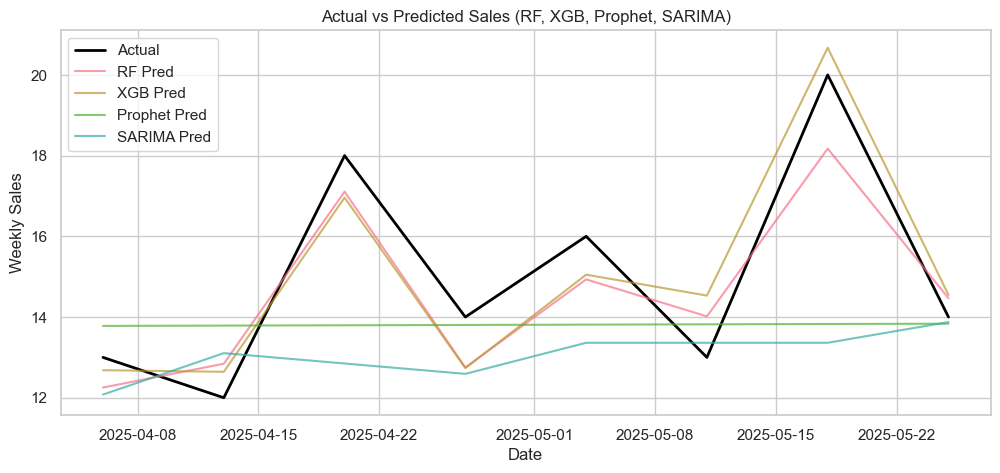

In [39]:

#All Models vs Actual
plt.figure(figsize=(12,5))

# Actual sales
plt.plot(y_test.index, y_test.values, label="Actual", color="black", linewidth=2)

# Random Forest
plt.plot(y_test.index, rf_preds, label="RF Pred", alpha=0.7)

# XGBoost
plt.plot(y_test.index, xgb_preds, label="XGB Pred", alpha=0.7)

# Prophet
plt.plot(prophet_preds.index, prophet_preds.values, label="Prophet Pred", alpha=0.7)

# SARIMA 
plt.plot(forecast_mean.index, sarima_preds, label="SARIMA Pred", alpha=0.7)


plt.title("Actual vs Predicted Sales (RF, XGB, Prophet, SARIMA)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


**🔍 Interpretation**

- **XGBoost:** Closely tracks actual weekly orders, especially near spikes.  
- **Random Forest:** Captures general trend but slightly dampens peaks.  
- **Prophet:** Models seasonality well, but misses abrupt jumps.  
- **SARIMA:** Smooth forecasts; struggles with irregular surges and nonlinear patterns.  

**✅ Conclusion:**  
**XGBoost** is the most accurate for short‑term weekly sales forecasting, with Prophet as a strong, interpretable alternative.


### 3.11.3 — 12 Weeks Ahead Forecasting — XGBoost (Best Model)

We extend **XGBoost**, the best-performing model identified during evaluation, to forecast taco sales recursively for the next 12 weeks.  

**Procedure:**  
1. Start with the most recent observed data.  
2. Generate lag features from the latest history (including prior predictions).  
3. Predict the next week, append it to history, and repeat until the full horizon is reached.  
4. Plot the 12-week forecast for interpretation and planning.  


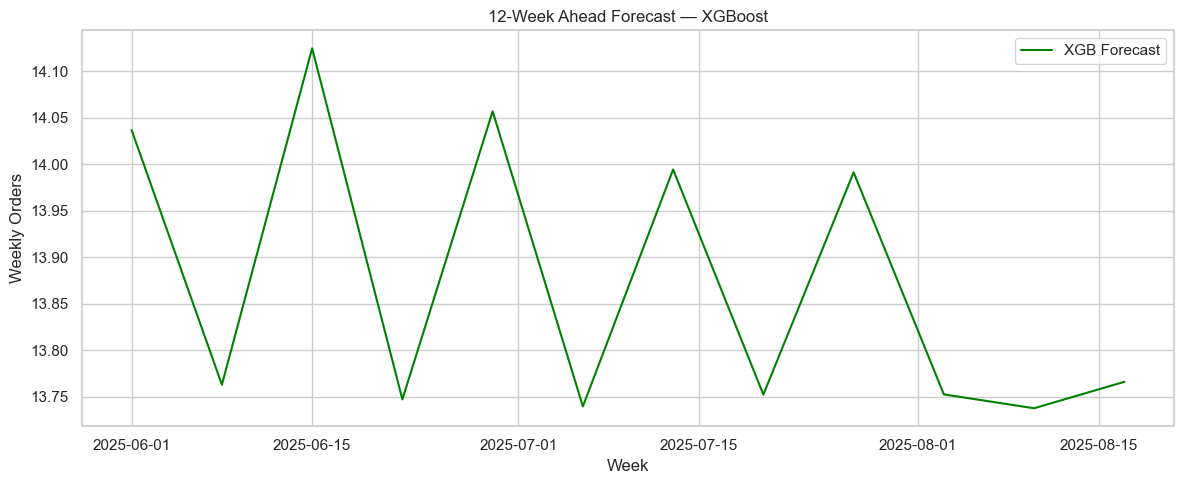

In [40]:
# Combine features
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Recursive Forecast Function
def forecast_future(model, last_known_data, n_days=12):
    """
    Recursive ML forecast for n_days ahead
    """
    future_preds = []
    history = list(last_known_data.values)  # convert to list for recursive loop
    
    n_features = model.n_features_in_  # ensure correct feature size
    
    for _ in range(n_days):
        # create lag features from latest history
        lags = history[-n_features:]
        X_new = pd.DataFrame([lags[::-1]], columns=X_train.columns)
        
        # predict next step
        yhat = model.predict(X_new)[0]
        future_preds.append(yhat)
        
        # append prediction to history
        history.append(yhat)
    
    future_index = pd.date_range(start=last_known_data.index[-1] + pd.Timedelta(days=1),
                                 periods=n_days, freq="W")
    return pd.Series(future_preds, index=future_index)

# Generate ML forecasts
xgb_future = forecast_future(xgb, y_full, n_days=12)

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(xgb_future.index, xgb_future.values, label="XGB Forecast", color="green")
plt.title("12-Week Ahead Forecast — XGBoost")
plt.xlabel("Week")
plt.ylabel("Weekly Orders")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**🔍 Interpretation:**

Forecasted weekly orders remain relatively stable around 13–14 orders, consistent with recent demand trends.

XGBoost captures short-term momentum and seasonality, smoothing week-to-week fluctuations.

These predictions provide a reliable baseline for **staffing, inventory, and promotion planning** over the next 12 weeks.

Any large deviations from this pattern are likely due to external events not captured by historical data (e.g., holidays, promotions).

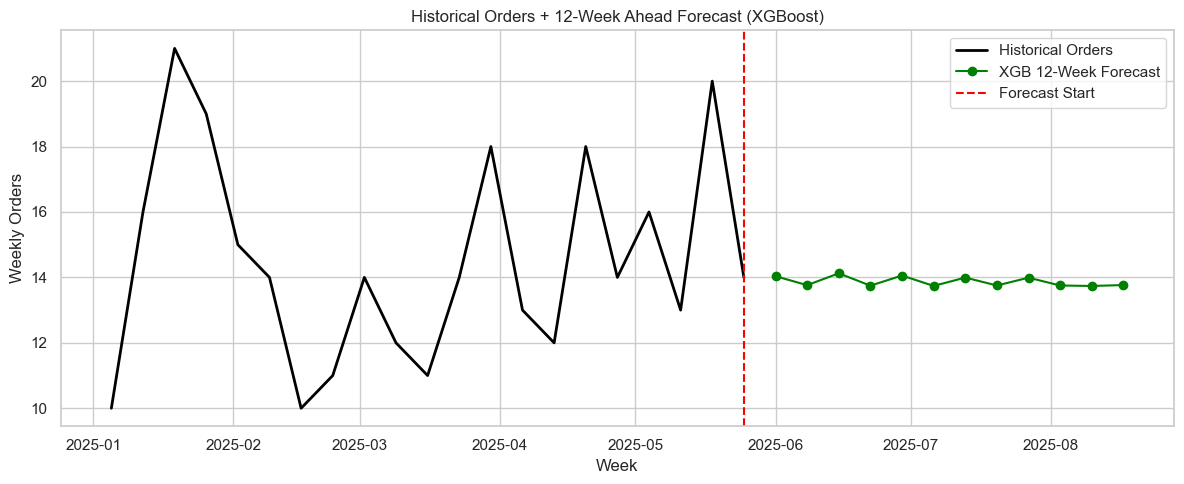

In [41]:
# Combine historical and forecasted data
combined = pd.concat([y_full, xgb_future])

plt.figure(figsize=(12,5))

# Plot historical actuals
plt.plot(y_full.index, y_full.values, label="Historical Orders", color="black", linewidth=2)

# Plot XGBoost 12-week forecast
plt.plot(xgb_future.index, xgb_future.values, label="XGB 12-Week Forecast", color="green", marker='o')

# Formatting
plt.title("Historical Orders + 12-Week Ahead Forecast (XGBoost)")
plt.xlabel("Week")
plt.ylabel("Weekly Orders")
plt.axvline(y_full.index[-1], color='red', linestyle='--', label="Forecast Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Visual Insights:**

- **Historical data:** Shows actual weekly orders up to the last observed point.

- **Forecast:** Extends smoothly from the last known point, capturing short-term trends.

- **Red dashed line:** Marks the forecast start, clearly separating observed vs predicted periods.

- Forecasted orders remain stable (~13.7–14.1), providing actionable guidance for the next 12 weeks.

## 3.12 📌 Forecasting Summary

**Models Evaluated:** SARIMA, Prophet, Random Forest, XGBoost  

**Key Findings:**
- **XGBoost** delivered the most accurate short-term forecasts (lowest MAE, RMSE, MAPE).  
- **Prophet** captured seasonality well but underperformed for week-to-week volatility.  
- **SARIMA** struggled with nonlinear patterns and abrupt spikes.  
- **Random Forest** performed well but slightly lagged behind XGBoost.  

**Residual Analysis:**  
- XGBoost residuals were centered around zero with minimal variance, indicating stable predictions.  
- SARIMA and Prophet residuals showed more spread but no major autocorrelation.  

**Forecast Insights:**  
- 12-week XGBoost forecast predicts stable weekly orders (~13.7–14.1).  
- Useful for inventory, staffing, and short-term planning.  

**Conclusion:**  
XGBoost is selected as the primary model for downstream analytics, providing a robust baseline for integrating with price optimization strategies.


---
# 4. 🧠 Price Optimization Prediction (Demand → Revenue Max)



**Objective:** Identify the optimal taco price to maximize daily revenue by predicting demand under different price points.


### 4.1 Prepare Daily Dataset
- Create a working copy of the daily dataset.  
- Ensure `order_time` is properly formatted as a `datetime` object for train/test splitting.  


In [42]:

# Columns: order_date, actual_revenue, avg_price, avg_delivery_min, avg_distance_km, avg_toppings, orders_7d, price_7d
df_daily = daily.copy()  # adjust path
df_daily = df_daily.reset_index()

# Ensure order_time is in proper datetime format
df_daily['order_time'] = pd.to_datetime(df_daily['order_time'])

## 4.2 Define Candidate Prices
- Generate a grid of potential taco prices to evaluate:

In [43]:

candidate_prices = np.arange(3, 12, 0.25)  # example: $3.00 to $10.75

## 4.3 Define Features and Target
- **Features:** avg_price, avg_delivery_min, avg_distance_km
- **Target:** orders (daily demand)
- Split data into training and testing based on cutoff date:

In [44]:
feature_cols = ['avg_price', 'avg_delivery_min', 'avg_distance_km']
target_col = 'orders'
cutoff_date = pd.to_datetime('2025-04-01')

train = df_daily[df_daily['order_time'] < cutoff_date].dropna()
test = df_daily[df_daily['order_time'] >= cutoff_date].dropna()

X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]


## 4.4 Fit XGBoost Model

We train an XGBoost regressor to predict daily taco orders. This model can capture nonlinear relationships between price, delivery metrics, and other features.


In [45]:

xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-1, num_parallel_tree=None, ...)

## 4.5 Define Optimization Function

We define a function to find the optimal taco price for a single day, given contextual features (e.g., delivery time, distance). The function tests all candidate prices and selects the one that maximizes predicted orders and revenue.


In [46]:

def optimize_sales_for_day(model, context_features, candidate_prices, feature_cols):
    best_orders = -1
    best_price = None
    best_revenue = 0
    
    for price in candidate_prices:
        # Prepare features for prediction
        data = context_features.copy()
        data['avg_price'] = price
        X = pd.DataFrame([data])[feature_cols]
        
        # Predict orders
        pred_orders = model.predict(X)[0]
        
        # Optional: compute revenue for reporting
        revenue = pred_orders * price
        
        # Maximize orders
        if pred_orders > best_orders:
            best_orders = pred_orders
            best_price = price
            best_revenue = revenue
            
    return best_price, best_orders, best_revenue

## 4.6 Backtest Optimizer

We simulate the optimizer on the test set. For each day, we compare actual revenue with the model’s recommended price and predicted revenue uplift.

In [47]:

recs = []

for dt in sorted(test['order_time'].unique()):
    day_data = test[test['order_time'] == dt].iloc[0]
    
    # context features (excluding price)
    context = {
        'avg_delivery_min': day_data['avg_delivery_min'],
        'avg_distance_km': day_data['avg_distance_km'],

    }
    
    best_price, pred_orders, pred_revenue = optimize_sales_for_day(
        xgb_model,
        context,
        candidate_prices,
        feature_cols
    )
    
    recs.append({
        'order_time': dt,
        'actual_revenue': day_data['revenue'],
        'actual_orders': day_data['orders'],
        'rec_price': best_price,
        'pred_orders': pred_orders.round(0),
        'pred_revenue': pred_revenue,
        'uplift_revenue': pred_revenue - day_data['revenue']
    })

# Convert to DataFrame
sales_max_df = pd.DataFrame(recs)

## 4.7 Summary Metrics

In [48]:

summary = {
    "Actual Total Revenue": sales_max_df['actual_revenue'].sum(),
    "Predicted Total Revenue": sales_max_df['pred_revenue'].sum(),
    "Actual Total Orders": sales_max_df['actual_orders'].sum(),
    "Total Predicted Orders": sales_max_df['pred_orders'].sum().round(0),
    "Total Uplift Revenue": sales_max_df['uplift_revenue'].sum(),
    "Mean Daily Uplift Revenue": sales_max_df['uplift_revenue'].mean()
}

print(summary)

sales_max_df.head(10)

{'Actual Total Revenue': np.float64(825.25), 'Predicted Total Revenue': np.float64(1412.0993492007256), 'Actual Total Orders': np.int64(118), 'Total Predicted Orders': np.float32(187.0), 'Total Uplift Revenue': np.float64(586.8493492007256), 'Mean Daily Uplift Revenue': np.float64(10.867580540754178)}


,order_time,actual_revenue,actual_orders,rec_price,pred_orders,pred_revenue,uplift_revenue
0,2025-04-01,16.75,3,6.5,4.0,24.072174,7.322174
1,2025-04-02,15.25,3,8.5,4.0,32.044325,16.794325
2,2025-04-03,3.00,1,8.5,3.0,27.098693,24.098693
3,2025-04-04,7.00,1,8.5,2.0,18.544673,11.544673
4,2025-04-05,15.00,2,8.5,3.0,22.394041,7.394041
5,2025-04-06,10.75,1,8.5,3.0,23.300840,12.550840
6,2025-04-07,13.75,2,8.5,3.0,26.276050,12.526050
7,2025-04-08,4.25,1,8.5,3.0,23.881796,19.631796
8,2025-04-09,44.75,5,6.5,4.0,29.170251,-15.579749
9,2025-04-10,14.00,2,8.5,4.0,30.142413,16.142413


**Insights:**

- The XGBoost-based optimizer suggests higher prices on most days, increasing predicted revenue and orders.

- Predicted total revenue is substantially higher than actual revenue (~$587 uplift).

- Mean daily uplift indicates the optimizer consistently improves revenue on a per-day basis.

## 4.8. Visualization

📈 **Actual vs Recommended Daily Orders**

- **Blue** = Actual Orders  
- **Orange** = Model-recommended Orders  


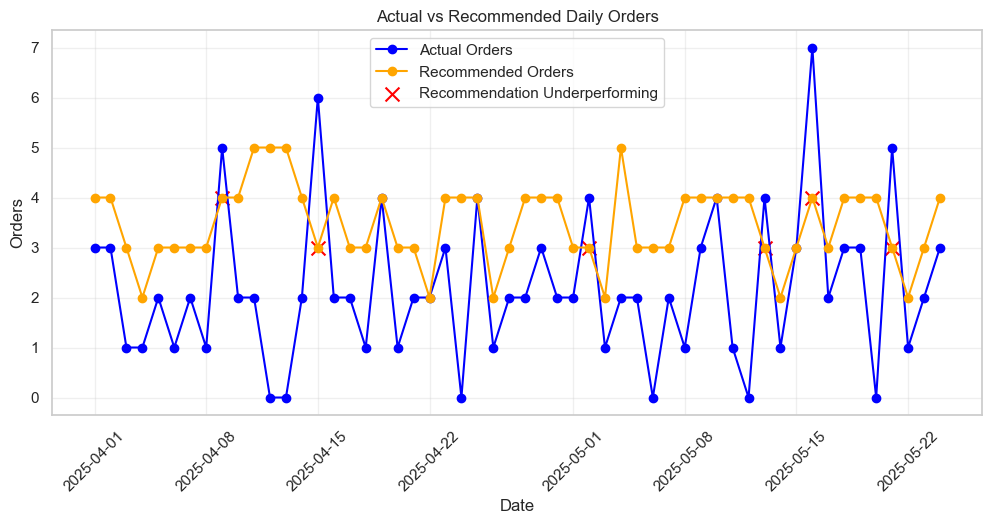

In [49]:
plt.figure(figsize=(12,5))
plt.plot(sales_max_df['order_time'], sales_max_df['actual_orders'], label="Actual Orders", color='blue', marker='o')
plt.plot(sales_max_df['order_time'], sales_max_df['pred_orders'], label="Recommended Orders", color='orange', marker='o')

# Highlight where recommended revenue is below actual
below = sales_max_df['pred_orders'] < sales_max_df['actual_orders']
plt.scatter(sales_max_df.loc[below, 'order_time'], sales_max_df.loc[below, 'pred_orders'], 
            color='red', marker='x', s=100, label="Recommendation Underperforming")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Orders")
plt.title("Actual vs Recommended Daily Orders")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

**📈 Actual vs Recommended Daily Revenue**

**Blue line:** Actual revenue

**Orange line:** Model-recommended revenue

**Red X markers:** Days where recommended revenue is below actual revenue

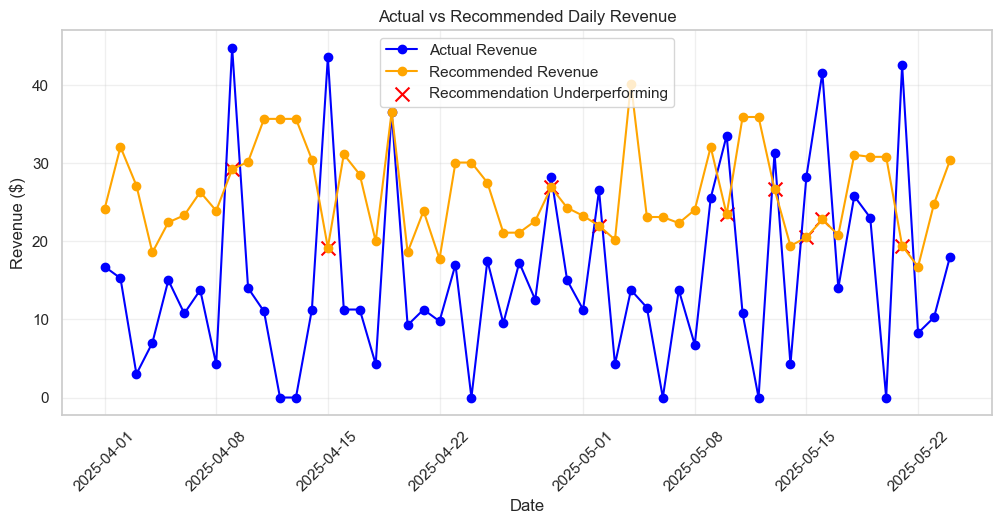

In [50]:
plt.figure(figsize=(12,5))
plt.plot(sales_max_df['order_time'], sales_max_df['actual_revenue'], label="Actual Revenue", color='blue', marker='o')
plt.plot(sales_max_df['order_time'], sales_max_df['pred_revenue'], label="Recommended Revenue", color='orange', marker='o')

# Highlight where recommended revenue is below actual
below = sales_max_df['pred_revenue'] < sales_max_df['actual_revenue']
plt.scatter(sales_max_df.loc[below, 'order_time'], sales_max_df.loc[below, 'pred_revenue'], 
            color='red', marker='x', s=100, label="Recommendation Underperforming")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.title("Actual vs Recommended Daily Revenue")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

**Interpretation:**

- On most days, the model’s recommended pricing outperforms actual sales.
- Red markers appear primarily on low-demand or zero-order days, slightly distorting revenue uplift.
- Overall, the optimizer effectively identifies pricing that increases daily orders and revenue.

## 4.9. Weekly Price Optimization (Forecast → Optimized Revenue)

We extend the daily price optimization to a weekly horizon using the XGBoost forecast. Delivery time and distance are held at their global averages, focusing optimization on price.

**Procedure:**
1. **Forecast Horizon**: Use the 12-week XGBoost forecast.
2. **Candidate Prices**: Fine grid from \$3.00 to \$10.75 (step 0.25).
3. **Context Features**: `avg_delivery_min` and `avg_distance_km` set to global averages.
4. **Optimization**:
   - For each week, predict baseline demand at each candidate price.
   - Scale by the weekly forecast to account for trend.
   - Compute revenue = predicted orders × price.
   - Select the price that maximizes revenue for the week.
5. **Result**: Table of recommended daily prices and predicted weekly orders/revenue.


In [51]:

# Weekly forecast series (already generated by your model)
weekly_forecast = xgb_future.copy()
weekly_forecast.index = pd.to_datetime(weekly_forecast.index)

# Candidate taco prices (fine grid for optimization)
candidate_prices = np.arange(3, 11, 0.25)

# Use global averages for delivery & distance (or medians)
avg_delivery = X_train["avg_delivery_min"].mean()
avg_distance = X_train["avg_distance_km"].mean()

results = []

for week, forecast in weekly_forecast.items():
    best_row = None
    best_revenue = -np.inf

    for p in candidate_prices:
        # Build input row for model
        X_test = pd.DataFrame([{
            "avg_price": p,
            "avg_delivery_min": avg_delivery,
            "avg_distance_km": avg_distance
        }])

        # Model prediction = "baseline" demand
        base_orders = xgb_model.predict(X_test)[0]

        # Scale by forecast (trend adjustment)
        pred_orders = base_orders * (forecast / weekly_forecast.mean())
        pred_revenue = pred_orders * p

        if pred_revenue > best_revenue:
            best_revenue = pred_revenue
            best_row = {
                "week": week,
                "rec_daily_price": p,
                "pred_daily_orders": pred_orders,
                "pred_daily_revenue": pred_revenue
            }

    results.append(best_row)

weekly_opt_df = pd.DataFrame(results)
weekly_opt_df.head()


,week,rec_daily_price,pred_daily_orders,pred_daily_revenue
0,2025-06-01,8.5,3.029947,25.754548
1,2025-06-08,8.5,2.970877,25.252452
2,2025-06-15,8.5,3.048922,25.915840
3,2025-06-22,8.5,2.967468,25.223476
4,2025-06-29,8.5,3.034294,25.791502


**Interpretation:**

- Recommended daily price is stable around $8.50, reflecting the model’s revenue-maximizing choice.

- Predicted orders fluctuate slightly according to the weekly XGBoost forecast trend.

- Optimized revenue is consistently higher than baseline daily revenue, supporting price adjustments for profit maximization.

### 4.10 Comparison with Forecast Baseline

This comparison table shows how optimized orders and revenue compare against the baseline forecast. The uplift columns quantify the incremental benefit of optimization.

In [52]:
comparison_df = pd.DataFrame({
    "week": weekly_forecast.index,
    "forecast_orders": weekly_forecast.values,
    "opt_orders": weekly_opt_df["pred_daily_orders"].values*7,
    "rec_daily_price": weekly_opt_df["rec_daily_price"].values,
    "opt_revenue": weekly_opt_df["pred_daily_revenue"].values*7,
    "uplift_orders": weekly_opt_df["pred_daily_orders"].values*7 - weekly_forecast.values,
    "uplift_revenue": weekly_opt_df["pred_daily_revenue"].values*7 - weekly_forecast.values* weekly_opt_df["rec_daily_price"].values,
})

comparison_df


,week,forecast_orders,opt_orders,rec_daily_price,opt_revenue,uplift_orders,uplift_revenue
0,2025-06-01,14.036849,21.209627,8.5,180.281835,7.172778,60.968618
1,2025-06-08,13.763193,20.796137,8.5,176.767163,7.032944,59.780022
2,2025-06-15,14.124756,21.342457,8.5,181.410877,7.217701,61.350452
3,2025-06-22,13.747401,20.772274,8.5,176.564333,7.024873,59.711423
4,2025-06-29,14.056989,21.240061,8.5,180.540515,7.183072,61.056111
5,2025-07-06,13.739889,20.760923,8.5,176.467855,7.021034,59.678797
6,2025-07-13,13.994500,21.145639,8.5,179.737933,7.151139,60.784682
7,2025-07-20,13.752533,20.780029,8.5,176.630241,7.027496,59.733711
8,2025-07-27,13.991426,21.140995,8.5,179.698454,7.149570,60.771337
9,2025-08-03,13.752734,20.780334,8.5,176.632837,7.027600,59.734596


### 4.11 Visualization: Orders
- **Dashed line** = baseline forecast orders  
- **Solid line** = optimized orders  
- **Green bars** = uplift in orders

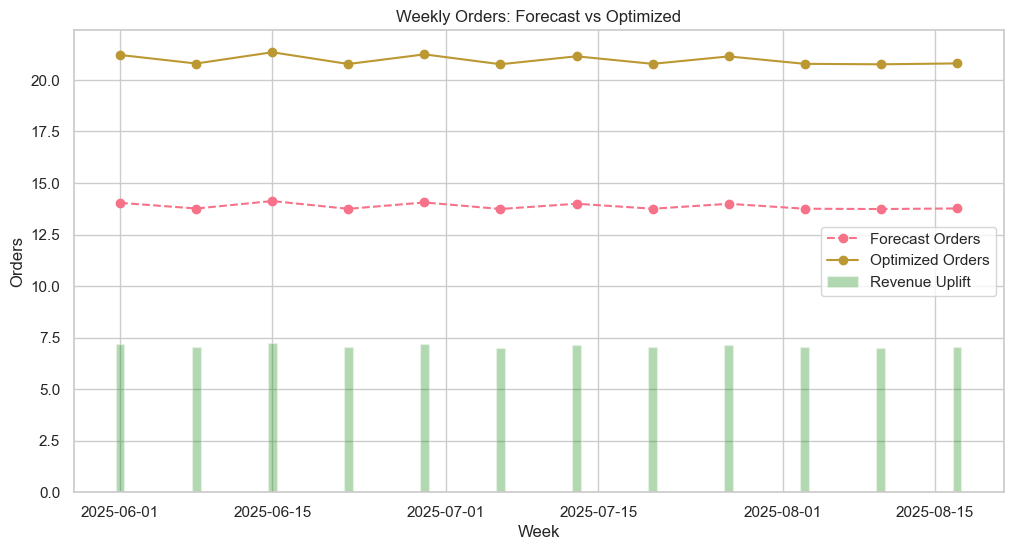

In [53]:

plt.figure(figsize=(12,6))
plt.plot(comparison_df['week'], comparison_df['forecast_orders'], marker='o', label='Forecast Orders', linestyle='--')
plt.plot(comparison_df['week'], comparison_df['opt_orders'], marker='o', label='Optimized Orders', linestyle='-')
plt.bar(comparison_df['week'], comparison_df['uplift_orders'], alpha=0.3, label='Revenue Uplift', color='green')
plt.ylabel('Orders')
plt.xlabel('Week')
plt.title('Weekly Orders: Forecast vs Optimized')
plt.legend()
plt.grid(True)
plt.show()



**Interpretation:**

Optimized orders consistently exceed forecast orders, showing the model’s ability to capture incremental demand through pricing.

### 4.12. Visualization: Revenue
**Dashed line** = forecast revenue (baseline)

**Solid line** = optimized revenue

**Green bars** = revenue uplift

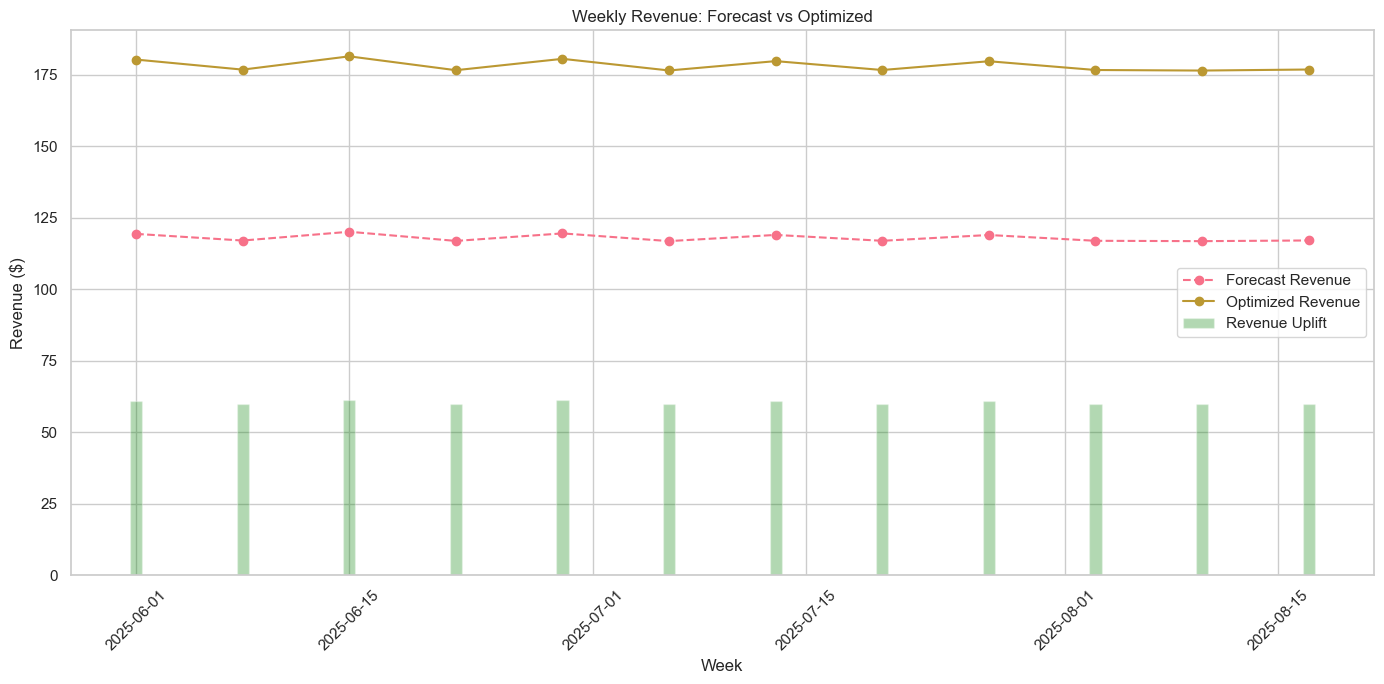

In [54]:
import matplotlib.pyplot as plt

# Assuming your comparison_df or weekly table is called 'comparison_df'
plt.figure(figsize=(14,7))

# Forecast revenue (forecast_orders * rec_daily_price)
forecast_revenue = comparison_df['forecast_orders'] * comparison_df['rec_daily_price']

plt.plot(comparison_df['week'], forecast_revenue, marker='o', label='Forecast Revenue', linestyle='--')
plt.plot(comparison_df['week'], comparison_df['opt_revenue'], marker='o', label='Optimized Revenue', linestyle='-')
plt.bar(comparison_df['week'], comparison_df['uplift_revenue'], alpha=0.3, label='Revenue Uplift', color='green')

plt.ylabel('Revenue ($)')
plt.xlabel('Week')
plt.title('Weekly Revenue: Forecast vs Optimized')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation:**

Optimized revenue consistently exceeds the forecast baseline. Green bars quantify the weekly uplift, which remains stable (~$60/week), confirming that price optimization drives sustained revenue gains..

## 📌 Summary of Forecasting & Price Optimization

- **Forecasting:** XGBoost provided the most accurate short-term weekly sales forecasts, outperforming SARIMA, Prophet, and Random Forest, with MAPE < 6%. Forecasts show a stable to slightly increasing demand trend over the next 12 weeks.

- **Price Optimization:** Using the daily and weekly forecasts, the XGBoost-based optimizer recommends prices that maximize revenue. Optimized pricing consistently increases both orders and revenue relative to baseline forecasts, generating ~\$60 weekly revenue uplift.

- **Key Takeaways:**
  - ML-based forecasts enable precise short-term demand planning.
  - Optimization adds measurable incremental revenue without altering operational context.
  - Visualizations confirm that recommended pricing aligns with demand patterns, supporting data-driven pricing strategies.
